In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import os
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import product

import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
from flymazerl.agents.classical import *
from flymazerl.gym.environment import ymaze_baiting,ymaze_static
from flymazerl.utils import generate_params_from_fits,get_schedule_histories, get_schedule_values,get_agent_value_history
from flymazerl.utils import generate_random_schedule_with_blocks
from scipy import stats
import gym
import pickle

import matplotlib.colors as mcolors
import matplotlib as mpl

from joblib import Parallel, delayed
import multiprocessing

# create a color map using a list of hex values for the IBM colorblind safe palette
hex_list = ['#648fff','#785ef0','#dc267f','#fe6100','#ffb000']
cmap = mpl.colors.LinearSegmentedColormap.from_list('ibm_cbs', hex_list)

def rgba_to_hex(rgba):
    return mcolors.rgb2hex(rgba)

def change_lightness(color, amount=0.5):
    """ amount can be between -1 and 1 """
    import colorsys
    try:
        c = mcolors.to_rgb(color)
        c = colorsys.rgb_to_hls(*c)
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    except ValueError:
        return color

def pvalue_to_stars(pvalue):
    if pvalue < 0.0001:
        return '****'
    elif pvalue < 0.001:
        return '***'
    elif pvalue < 0.01:
        return '**'
    elif pvalue < 0.05:
        return '*'
    else:
        return 'ns'

def pairedCohensD(x,y):
    """ Calculate the paired cohens d for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    return (np.mean(x-y) / np.std(x-y,ddof=1))

def cliffsDelta(x,y):
    """ Calculate the cliffs delta for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    prod = np.array(list(product(x,y)))
    diffs = np.int32(prod[:,0]<prod[:,1]) - np.int32(prod[:,0]>prod[:,1])
    return np.mean(diffs)

def pairedRankBiserialCorrelation(x,y):
    """ Calculate the paired rank biserial correlation for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    # calculate the signed rank
    signed_rank = np.sign(x-y)*stats.rankdata(np.abs(x-y))
    # get sum of positive and negative ranks
    pos_rank = np.sum(signed_rank[signed_rank>0])
    neg_rank = -np.sum(signed_rank[signed_rank<0])
    # calculate the proportion of positive and negative ranks
    pos_prop = pos_rank/(pos_rank+neg_rank)
    neg_prop = neg_rank/(pos_rank+neg_rank)
    # calculate the difference in proportion
    return pos_prop-neg_prop

def delta_to_effect(delta):
    """ Convert a cliffs delta to effect size """
    delta = np.abs(delta)
    if delta < 0.147:
        return 'neg'
    elif delta < 0.33:
        return '^'
    elif delta < 0.474:
        return '^^'
    elif delta > 0.474:
        return '^^^'
    else:
        return ''

def d_to_effect(d):
    """ Convert a Cohen's d to effect size """
    d = np.abs(d)
    if d < 0.2:
        return 'neg'
    elif d < 0.5:
        return '^'
    elif d < 0.8:
        return '^^'
    elif d > 0.8:
        return '^^^'
    else:
        return ''

def r_to_effect(r):
    """ Convert a rank biserial correlation to effect size according to Funder (2019)"""
    r = np.abs(r)
    if r < 0.1:
        return 'neg'
    elif r < 0.3:
        return '^'
    elif r < 0.4:
        return '^^'
    elif r > 0.4:
        return '^^^'
    else:
        return ''

def smoothen(x,width):
    if len(x.shape) == 1:
        # check if the first index is a number
        if isinstance(x[0],(int,float)):
            # add padding with 0.5 to avoid edge effects
            x = np.concatenate([np.ones(width-1)*0.5, x])
            # convolve with a boxcar
            x = np.convolve(x, np.ones(width)/width, mode='valid')
            return x
        else:
            xs = []
            for x_ in x:
                xs.append(smoothen(x_,width))
            return np.array(xs)
    elif len(x.shape) == 2:
        xs = []
        for i in range(x.shape[0]):
            xs.append(smoothen(x[i],width))
        return np.array(xs)
    elif len(x.shape) == 3:
        xs = []
        for i in range(x.shape[0]):
            xs.append(smoothen(x[i],width))
        return np.array(xs)
    else:
        raise ValueError("x must be 1, 2 or 3 dimensional")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
model_database = pd.read_csv("../../../FlYMazeRL/model_description_rajagopalan.csv")
# filter to only acceptreject models
model_database = model_database[model_database['Variant'] == 'acceptreject']
# generate maps
model_name_map = {model_database.iloc[i]['SHORTCODE']:model_database.iloc[i]['Model'] for i in range(len(model_database))}
model_simple_abv_map = {model_database.iloc[i]['SHORTCODE']:model_database.iloc[i]['ModelAbv'] for i in range(len(model_database))}
model_class_name_map = {model_database.iloc[i]['AgentClass']:model_database.iloc[i]['SHORTCODE'] for i in range(len(model_database))}

# show the unique models
model_database.SHORTCODE.unique(), len(model_database.SHORTCODE.unique())

(array(['RBR', 'FRBR', 'IQBR', 'CQBR', 'FQBR', 'FCQBR', 'DFQBR', 'DFCQBR',
        'DEQBR', 'DECQBR', 'OSQBR', 'OSCQBR', 'FOSQBR', 'FOSCQBR',
        'DFOSQBR', 'DFOSCQBR', 'SBR', 'ESBR', 'HQBR', 'FHQBR', 'DFHQBR',
        'HCQBR', 'FHCQBR', 'DFHCQBR'], dtype=object),
 24)

In [3]:
model_database

Model Category                                              Model  \
7    Value-Based RL                                RPE-free Q-Learning   
8    Value-Based RL                                RPE-free Q-Learning   
9    Value-Based RL                                RPE-free Q-Learning   
17   Value-Based RL                     Forgetting RPE-free Q-Learning   
18   Value-Based RL                     Forgetting RPE-free Q-Learning   
..              ...                                                ...   
482  Value-Based RL  Differential Forgetting Long-Term Habit-Value ...   
483  Value-Based RL  Differential Forgetting Long-Term Habit-Value ...   
484  Value-Based RL  Differential Forgetting Long-Term Habit-Value ...   
485  Value-Based RL  Differential Forgetting Long-Term Habit-Value ...   
486  Value-Based RL  Differential Forgetting Long-Term Habit-Value ...   

        ModelAbv       Variant Parameter Name Parameter Type  \
7          RF-QL  acceptreject          alpha   learningrule   
8          RF-QL  acceptreject         weight         policy   
9          RF-QL  acceptreject      intercept         policy   
17       F-RF-QL  acceptreject          alpha   learningrule   
18       F-RF-QL  acceptreject         weight         policy   
..           ...           ...            ...            ...   
482  DF-LT-HV-QL  acceptreject       weight_b   learningrule   
483  DF-LT-HV-QL  acceptreject        theta_r         policy   
484  DF-LT-HV-QL  acceptreject        theta_h         policy   
485  DF-LT-HV-QL  acceptreject         weight         policy   
486  DF-LT-HV-QL  acceptreject      intercept         policy   

               Description Prior Distribution Default Prior Distribution  \
7            Learning Rate               Beta                  Beta(1,1)   
8           Q-value weight             Normal                Normal(0,1)   
9        Q-value intercept             Normal                Normal(0,1)   
17           Learning Rate               Beta                  Beta(1,1)   
18          Q-value weight             Normal                Normal(0,1)   
..                     ...                ...                        ...   
482                   Bias               Beta                  Beta(1,1)   
483  Reward scaling factor               Beta                  Beta(1,1)   
484   Habit scaling factor               Beta                  Beta(1,1)   
485         Q-value weight             Normal                Normal(0,1)   
486      Q-value intercept             Normal                Normal(0,1)   

                               AgentClass  ... OptimizationAlgorithm  \
7              RewardLearner_acceptreject  ...                  NUTS   
8              RewardLearner_acceptreject  ...                  NUTS   
9              RewardLearner_acceptreject  ...                  NUTS   
17   ForgettingRewardLearner_acceptreject  ...                  NUTS   
18   ForgettingRewardLearner_acceptreject  ...                  NUTS   
..                                    ...  ...                   ...   
482             DFHCQLearner_acceptreject  ...                  NUTS   
483             DFHCQLearner_acceptreject  ...                  NUTS   
484             DFHCQLearner_acceptreject  ...                  NUTS   
485             DFHCQLearner_acceptreject  ...                  NUTS   
486             DFHCQLearner_acceptreject  ...                  NUTS   

                                                FitDir RPE Forgetting  \
7    acceptreject/rajagopalan2022/RBR_2022_04_09_19...   -          -   
8    acceptreject/rajagopalan2022/RBR_2022_04_09_19...   -          -   
9    acceptreject/rajagopalan2022/RBR_2022_04_09_19...   -          -   
17   acceptreject/rajagopalan2022/FRBR_2022_04_22_2...   -          +   
18   acceptreject/rajagopalan2022/FRBR_2022_04_22_2...   -          +   
..                                                 ...  ..        ...   
482  acceptreject/rajagopalan2022/DFHCQBR_2022_10_0...   +

In [4]:
# make formatted model description
df = model_database.copy()
df['Model'] = df['SHORTCODE'].map(model_name_map)
df['Abbreviation'] = df['SHORTCODE'].map(model_simple_abv_map)
# group by model and keep only the count and SHORTCODE
df = df.groupby(['Model']).aggregate({'Abbreviation':['count','first']}).reset_index()
df.columns = ['Model','Number of Parameters','Abbreviation']
# invert string of model to create new column
df['InvModel'] = df['Model'].apply(lambda x: x[::-1])
df = df.sort_values(by=['Number of Parameters','InvModel'],ascending=False, na_position = 'first').reset_index(drop=True).drop(columns=['InvModel'])
# save as csv and display
df.to_csv("tables/model_description.csv",index=False)
df

Model  Number of Parameters  \
0   Differential Forgetting Long-Term Habit-Value ...                    11   
1   Forgetting Long-Term Habit-Value Arbiter Q-Lea...                    10   
2            Long-Term Habit-Value Arbiter Q-Learning                    10   
3   Differential Forgetting Immediate Habit-Value ...                    10   
4   Forgetting Immediate Habit-Value Arbiter Q-Lea...                     9   
5            Immediate Habit-Value Arbiter Q Learning                     9   
6   Differential Forgetting Long-Term Omission Sen...                     6   
7        Differential Extinction Long-Term Q Learning                     5   
8        Differential Forgetting Long-Term Q Learning                     5   
9   Forgetting Long-Term Omission Sensitive Q Lear...                     5   
10           Long-Term Omission Sensitive Q Learning                      5   
11  Differential Forgetting Immediate Omission Sen...                     5   
12       Differential Forgetting Immediate Q-Learning                     4   
13                    Forgetting Long-Term Q Learning                     4   
14                               Long-Term Q Learning                     4   
15       Differential Extinction Immediate Q Learning                     4   
16                                     Expected SARSA                     4   
17                                              SARSA                     4   
18  Forgetting Immediate Omission Sensitive Q Lear...                     4   
19           Immediate Omission Sensitive Q Learning                      4   
20                    Forgetting Immediate Q-Learning                     3   
21                               Immediate Q-Learning                     3   
22                     Forgetting RPE-free Q-Learning                     3   
23                                RPE-free Q-Learning                     3   

   Abbreviation  
0   DF-LT-HV-QL  
1    F-LT-HV-QL  
2      LT-HV-QL  
3    DF-I-HV-QL  
4     F-I-HV-QL  
5       I-HV-QL  
6   DF-LT-OS-QL  
7      DE-LT-QL  
8      DF-LT-QL  
9    F-LT-OS-QL  
10     LT-OS-QL  
11   DF-I-OS-QL  
12      DF-I-QL  
13      F-LT-QL  
14        LT-QL  
15      DE-I-QL  
16       ESARSA  
17        SARSA  
18    F-I-OS-QL  
19      I-OS-QL  
20       F-I-QL  
21         I-QL  
22      F-RF-QL  
23        RF-QL

In [5]:
# Load all fits
model_dir = "Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/"
model_fits = {}
for i in os.listdir(model_dir):
    if i.endswith(".nc"):
        model_fits[i.split('_')[0]] = az.from_netcdf(os.path.join(model_dir, i))

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\xarray\core\pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")


In [6]:
# supress depreciation warnings
import warnings
warnings.filterwarnings("ignore")

# get all parameters in a common dataframe
df = []
for m in model_fits.keys():
    temp = az.summary(model_fits[m])
    temp['model'] = model_name_map[m]
    df.append(temp.rename_axis('parameter').reset_index()[['model', 'parameter', 'mean', 'sd', 'hdi_3%', 'hdi_97%', 'ess_bulk','ess_tail','r_hat']])
df = pd.concat(df).reset_index(drop=True)

In [8]:
df_mean_for_comparison = df.pivot_table(index='model', columns='parameter',values='mean', aggfunc='first')
df_sd_for_comparison = df.pivot_table(index='model', columns='parameter',values='sd', aggfunc='first')
# save
df_mean_for_comparison.to_csv("tables/parameter_means_rajagopalan.csv")
df_sd_for_comparison.to_csv("tables/parameter_sds_rajagopalan.csv")

In [7]:
# generate summary columns
df['summary'] = df['mean'].apply(lambda x: str(np.round(x,2)))+ \
        ' ('+df['hdi_3%'].apply(lambda x: str(np.round(x,2)))+'–' \
            +df['hdi_97%'].apply(lambda x: str(np.round(x,2)))+') [N=' \
            +df['ess_bulk'].apply(lambda x: str(int(x)))+'; R=' \
            +df['r_hat'].apply(lambda x: str(np.round(x,1)))+']'
df_summary = df.pivot_table(index='model', columns='parameter',values='summary', aggfunc='first')
# replace 'nan' with '-'
df_summary = df_summary.replace(np.nan,'-').reset_index()
df_summary.columns = ['Model',r'$\alpha$',r'$\alpha_h$',r'$\alpha_v$',r'$\gamma$',r'$c$',r'$\kappa$',r'$\kappa_v$',r'$\tau$',r'$\Theta$',r'$\theta_h$',r'$\theta_v$',r'$m$',r'$\w_b$',r'$\w_h$',r'$\w_v$']
col_order = ['Model',r'$\alpha$',r'$\kappa$',r'$\tau$',r'$\gamma$',r'$\Theta$',r'$m$',r'$c$',r'$\alpha_v$',r'$\alpha_h$',r'$\theta_v$',r'$\theta_h$',r'$\kappa_v$',r'$\w_v$',r'$\w_h$',r'$\w_b$']
df_summary = df_summary[col_order]
df_summary['InvModel'] = df_summary['Model'].apply(lambda x: x[::-1])
df_summary = df_summary.sort_values(by=['InvModel'],ascending=False, na_position = 'first').reset_index(drop=True).drop(columns=['InvModel'])
# split into two dataframes after 8th column
df_summary_1 = df_summary.iloc[:,:8]
df_summary_2 = pd.concat([df_summary.iloc[:,0],df_summary.iloc[:,8:]], axis=1).replace('-',np.nan)
# find indices where all non-model columns are nan
nan_indices = df_summary_2[df_summary_2.iloc[:,1:].isna().all(axis=1)].index
# remove nan indices from df_summary_2
df_summary_2 = df_summary_2.drop(nan_indices)
# replace nan with '-'
df_summary_2 = df_summary_2.replace(np.nan,'-')
# save as csv and display
df_summary_1.to_csv("tables/parameters_summary_1.csv",index=False)
df_summary_2.to_csv("tables/parameters_summary_2.csv",index=False)
df_summary_1


Model  \
0   Differential Forgetting Long-Term Habit-Value ...   
1   Forgetting Long-Term Habit-Value Arbiter Q-Lea...   
2            Long-Term Habit-Value Arbiter Q-Learning   
3   Differential Forgetting Immediate Habit-Value ...   
4   Forgetting Immediate Habit-Value Arbiter Q-Lea...   
5        Differential Forgetting Immediate Q-Learning   
6                     Forgetting Immediate Q-Learning   
7                                Immediate Q-Learning   
8                      Forgetting RPE-free Q-Learning   
9                                 RPE-free Q-Learning   
10           Immediate Habit-Value Arbiter Q Learning   
11       Differential Extinction Long-Term Q Learning   
12       Differential Forgetting Long-Term Q Learning   
13                    Forgetting Long-Term Q Learning   
14                               Long-Term Q Learning   
15       Differential Extinction Immediate Q Learning   
16                                     Expected SARSA   
17                                              SARSA   
18  Differential Forgetting Long-Term Omission Sen...   
19  Forgetting Long-Term Omission Sensitive Q Lear...   
20           Long-Term Omission Sensitive Q Learning    
21  Differential Forgetting Immediate Omission Sen...   
22  Forgetting Immediate Omission Sensitive Q Lear...   
23           Immediate Omission Sensitive Q Learning    

                             $\alpha$                           $\kappa$  \
0                                   -                                  -   
1                                   -                                  -   
2                                   -                                  -   
3                                   -                                  -   
4                                   -                                  -   
5   0.09 (0.06–0.13) [N=12238; R=1.0]  0.26 (0.17–0.36) [N=14113; R=1.0]   
6     0.13 (0.1–0.17) [N=8987; R=1.0]                                  -   
7   0.06 (0.05–0.08) [N=11123; R=1.0]                                  -   
8    0.42 (0.32–0.51) [N=9371; R=1.0]                                  -   
9    0.49 (0.12–0.94) [N=5593; R=1.0]                                  -   
10                                  -                                  -   
11    0.16 (0.12–0.2) [N=5178; R=1.0]                                  -   
12   0.25 (0.18–0.33) [N=8224; R=1.0]   0.08 (0.04–0.13) [N=7971; R=1.0]   
13  0.17 (0.13–0.22) [N=11326; R=1.0]                                  -   
14    0.16 (0.12–0.2) [N=5908; R=1.0]                                  -   
15  0.09 (0.06–0.12) [N=12335; R=1.0]                                  -   
16   0.15 (0.11–0.18) [N=6293; R=1.0]                                  -   
17   0.16 (0.12–0.19) [N=5984; R=1.0]                                  -   
18  0.26 (0.19–0.33) [N=12234; R=1.0]  0.06 (0.03–0.08) [N=10202; R=1.0]   
19    0.16 (0.12–0.2) [N=8634; R=1.0]                                  -   
20    0.14 (0.1–0.17) [N=5680; R=1.0]                                  -   
21  0.23 (0.16–0.29) [N=13150; R=1.0]   0.06 (0.04–0.09) [N=9167; R=1.0]   
22  0.14 (0.11–0.18) [N=13370; R=1.0]                                  -   
23   0.09 (0.07–0.1) [N=13807; R=1.0]                                  -   

                               $\tau$                          $\gamma$  \
0                                   -    0.7 (0.52–0.86) [N=351; R=1.0]   
1                                   -       0.4 (0.1–0.7) [N=45; R=1.0]   
2                                   -  0.64 (0.27–0.86) [N=3964; R=1.0]   
3                                   -                                 -   
4                                   -                                 -   
5                                   -                                 -   
6                                   -                                 -   
7                                   -                                 -   
8                                   -         

In [8]:
df_summary_2

Model  \
0   Differential Forgetting Long-Term Habit-Value ...   
1   Forgetting Long-Term Habit-Value Arbiter Q-Lea...   
2            Long-Term Habit-Value Arbiter Q-Learning   
3   Differential Forgetting Immediate Habit-Value ...   
4   Forgetting Immediate Habit-Value Arbiter Q-Lea...   
10           Immediate Habit-Value Arbiter Q Learning   

                           $\alpha_v$                         $\alpha_h$  \
0      0.22 (0.12–0.4) [N=159; R=1.0]     0.76 (0.05–1.0) [N=176; R=1.0]   
1       0.17 (0.08–0.31) [N=9; R=1.4]      0.58 (0.02–0.98) [N=9; R=1.4]   
2     0.25 (0.1–0.47) [N=3864; R=1.0]   0.18 (0.08–0.31) [N=3550; R=1.0]   
3      0.4 (0.17–0.7) [N=1236; R=1.0]    0.1 (0.04–0.14) [N=1175; R=1.0]   
4      0.24 (0.06–0.42) [N=18; R=1.2]      0.23 (0.02–0.9) [N=19; R=1.2]   
10  0.37 (0.18–0.57) [N=19919; R=1.0]  0.12 (0.09–0.16) [N=20928; R=1.0]   

                          $\theta_v$                        $\theta_h$  \
0    0.83 (0.6–1.0) [N=14140; R=1.0]   0.69 (0.34–1.0) [N=2596; R=1.0]   
1   0.87 (0.68–1.0) [N=15533; R=1.0]     0.7 (0.34–1.0) [N=311; R=1.0]   
2    0.72 (0.39–1.0) [N=6473; R=1.0]   0.87 (0.65–1.0) [N=8243; R=1.0]   
3    0.78 (0.43–1.0) [N=7028; R=1.0]   0.86 (0.63–1.0) [N=5365; R=1.0]   
4    0.88 (0.65–1.0) [N=6887; R=1.0]    0.78 (0.47–1.0) [N=234; R=1.0]   
10  0.55 (0.25–0.94) [N=9702; R=1.0]  0.91 (0.77–1.0) [N=15795; R=1.0]   

                         $\kappa_v$                               $\w_v$  \
0    0.04 (0.01–0.1) [N=217; R=1.0]   0.29 (-1.33–1.87) [N=22862; R=1.0]   
1                                 -  -0.04 (-1.83–1.65) [N=22251; R=1.0]   
2                                 -     0.08 (-1.83–2.0) [N=5968; R=1.0]   
3   0.16 (0.0–0.32) [N=9398; R=1.0]   0.13 (-1.56–1.83) [N=15459; R=1.0]   
4                                 -   0.03 (-1.69–1.79) [N=15275; R=1.0]   
10                                -   -0.79 (-2.39–0.8) [N=20996; R=1.0]   

                                  $\w_h$                               $\w_b$  
0      0.8 (-0.62–2.26) [N=11886; R=1.0]    -0.34 (-1.66–0.96) [N=837; R=1.0]  
1     1.17 (-0.33–2.61) [N=11215; R=1.0]     -0.28 (-1.63–0.93) [N=29; R=1.1]  
2      -1.05 (-2.43–0.4) [N=5231; R=1.0]   -0.29 (-1.26–0.75) [N=8641; R=1.0]  
3      -0.18 (-1.98–1.8) [N=3675; R=1.0]     0.1 (-1.02–1.16) [N=6310; R=1.0]  
4       0.73 (-1.34–2.45) [N=281; R=1.0]     -0.05 (-1.24–1.05) [N=65; R=1.0]  
10  -1.32 (-2.48–-0.18) [N=13601; R=1.0]  -0.12 (-1.18–0.94) [N=10741; R=1.0]

In [9]:
# check if comparison has been calculated and saved, if not calculate
if not os.path.isfile('data/waic_comparison.csv'):
    # calculate WAIC comparison
    comparison = az.compare(model_fits, ic = 'waic', scale = 'deviance')
    comparison.reset_index(inplace=True)
    comparison.rename(columns={'index':'model'}, inplace=True)
    comparison['model'] = comparison['model'].apply(lambda x: model_simple_abv_map[x])
    comparison = comparison.sort_values(by=['rank'], ascending=False)
    comparison.columns = ['Model','Rank','WAIC','pWAIC','dWAIC','Weight','SE','dSE','Warning','Scale']
    # calculate p-value
    est = comparison['dWAIC']
    se = comparison['dSE']
    comparison['p-val'] = 2*stats.norm.sf(np.abs(est/se))
    # add stars
    comparison['significance'] = comparison['p-val'].apply(lambda x: pvalue_to_stars(x))
    # calculate effect size
    comparison['effect_size'] = comparison['dWAIC']/comparison['dSE']
    # add effect size hash
    comparison['effect'] = comparison['effect_size'].apply(lambda x: d_to_effect(x))
    # save as csv
    comparison.to_csv("data/waic_comparison.csv",index=False)
else:
    # load from csv
    comparison = pd.read_csv("data/waic_comparison.csv")
comparison


Model  Rank         WAIC      pWAIC       dWAIC        Weight  \
0         RF-QL    23  4737.380875   1.938600  253.207414  0.000000e+00   
1          I-QL    22  4646.981109   2.522011  162.807648  2.488590e-12   
2       DE-I-QL    21  4643.346047   4.065228  159.172586  2.885597e-12   
3         SARSA    20  4582.409061   3.441894   98.235600  2.427223e-12   
4        ESARSA    19  4562.065930   3.705425   77.892469  9.363453e-13   
5       I-OS-QL    18  4558.224345   2.898181   74.050884  1.423887e-01   
6      DE-LT-QL    17  4553.607031   4.356413   69.433571  0.000000e+00   
7         LT-QL    16  4551.504777   3.677735   67.331316  0.000000e+00   
8        F-I-QL    15  4535.540407   2.687789   51.366947  2.107424e-12   
9      LT-OS-QL    14  4534.487899   4.142379   50.314438  7.228353e-02   
10      F-RF-QL    13  4526.066715   3.581427   41.893254  1.882075e-12   
11      DF-I-QL    12  4520.778474   3.456018   36.605013  1.608837e-12   
12      F-LT-QL    11  4517.938555   4.192764   33.765094  2.267972e-12   
13   F-LT-OS-QL    10  4509.503098   4.154265   25.329637  1.050009e-12   
14     DF-LT-QL     9  4508.366247   5.522368   24.192786  2.227681e-12   
15    F-I-OS-QL     8  4507.969856   3.532377   23.796395  7.670843e-13   
16    F-I-HV-QL     7  4504.069453  12.365465   19.895992  7.897285e-13   
17   F-LT-HV-QL     6  4501.679001   9.826689   17.505540  8.229103e-13   
18   DF-I-HV-QL     5  4498.552603   9.153040   14.379142  0.000000e+00   
19      I-HV-QL     4  4493.563856   5.930757    9.390395  4.314590e-02   
20     LT-HV-QL     3  4493.279119  11.564118    9.105658  6.998965e-13   
21   DF-I-OS-QL     2  4487.811474   4.274277    3.638013  0.000000e+00   
22  DF-LT-HV-QL     1  4485.671173   9.771486    1.497712  4.171031e-01   
23  DF-LT-OS-QL     0  4484.173461   5.218600    0.000000  3.250787e-01   

           SE        dSE  Warning     Scale         p-val significance  \
0   30.130912  33.007323    False  deviance  1.703287e-14         ****   
1   34.625464  26.739020    False  deviance  1.137840e-09         ****   
2   34.636552  26.350671    False  deviance  1.535884e-09         ****   
3   35.704999  20.405966    False  deviance  1.478923e-06         ****   
4   36.086800  19.819945    False  deviance  8.494431e-05         ****   
5   36.634062  22.875808    False  deviance  1.207584e-03           **   
6   36.162305  19.595144    False  deviance  3.949926e-04          ***   
7   36.239152  19.547669    False  deviance  5.721850e-04          ***   
8   39.254291  12.866138    False  deviance  6.540408e-05         ****   
9   37.086270  20.157931    False  deviance  1.255984e-02            *   
10  40.086051  10.819772    False  deviance  1.079830e-04          ***   
11  39.172610  10.256550    False  deviance  3.584282e-04          ***   
12  39.880190   8.747795    False  deviance  1.134610e-04          ***   
13  40.097913   7.658803    False  deviance  9.421412e-04          ***   
14  40.081162   6.638679    False  deviance  2.682072e-04          ***   
15  40.062600   7.614402    False  deviance  1.776949e-03           **   
16  39.843212   9.747326    False  deviance  4.123350e-02            *   
17  40.215205  10.329232    False  deviance  9.012147e-02           ns   
18  40.035603   7.895958    False  deviance  6.859526e-02           ns   
19  40.239281   6.516777    False  deviance  1.495969e-01           ns   
20  39.847593   5.570730    False  deviance  1.021426e-01           ns   
21  40.404088   3.693875    False  deviance  3.246844e-01           ns   
22  40.652012   9.199815    False  deviance  8.706774e-01           ns   
23  40.677271   0.000000    False  deviance           NaN           ns   

    effect_size effect  
0      7.671250    ^^^  
1      6.088766    ^^^  
2      6.040552    ^^^  
3      4.814063    ^^^  
4      3.930004    ^^^  
5      3.237083    ^^^  
6      3.543407    ^^^  
7      3.444468    ^^^  
8      3.992414    ^^^  
9      2.496012    ^^^  
10     3

In [10]:
model_barcode = model_database.groupby(['ModelAbv']).aggregate({i:'first' for i in model_database.columns[-8:]}).reset_index()
model_barcode['Barcode'] = model_barcode[model_barcode.columns[1:]].apply(lambda x: ("  ".join(x)), axis=1)
model_barcode['Barcode'] = model_barcode['Barcode'].apply(lambda x: x[::-1])
model_barcode = model_barcode.drop(columns=model_barcode.columns[1:-1])
model_barcode.columns = ['Model','Barcode']
model_barcode

Model                 Barcode
0       DE-I-QL  -  +  -  -  -  -  -  +
1      DE-LT-QL  -  +  -  -  +  -  -  +
2    DF-I-HV-QL  +  -  -  -  -  +  +  +
3    DF-I-OS-QL  -  -  -  +  -  +  +  +
4       DF-I-QL  -  -  -  -  -  +  +  +
5   DF-LT-HV-QL  +  -  -  -  +  +  +  +
6   DF-LT-OS-QL  -  -  -  +  +  +  +  +
7      DF-LT-QL  -  -  -  -  +  +  +  +
8        ESARSA  -  -  +  -  +  -  -  +
9     F-I-HV-QL  +  -  -  -  -  -  +  +
10    F-I-OS-QL  -  -  -  +  -  -  +  +
11       F-I-QL  -  -  -  -  -  -  +  +
12   F-LT-HV-QL  +  -  -  -  +  -  +  +
13   F-LT-OS-QL  -  -  -  +  +  -  +  +
14      F-LT-QL  -  -  -  -  +  -  +  +
15      F-RF-QL  -  -  -  -  -  -  +  -
16      I-HV-QL  +  -  -  -  -  -  -  +
17      I-OS-QL  -  -  -  +  -  -  -  +
18         I-QL  -  -  -  -  -  -  -  +
19     LT-HV-QL  +  -  -  -  +  -  -  +
20     LT-OS-QL  -  -  -  +  +  -  -  +
21        LT-QL  -  -  -  -  +  -  -  +
22        RF-QL  -  -  -  -  -  -  -  -
23        SARSA  -  -  +  -  +  -  -  +

In [11]:
# Load Training Data
training_choice_set = np.loadtxt('../../../FlYMazeRL/data/rajagopalan2022/training_choice_set.csv', delimiter=',')
training_reward_set = np.loadtxt('../../../FlYMazeRL/data/rajagopalan2022/training_reward_set.csv', delimiter=',')
# Load Test Data
test_choice_set = np.loadtxt('../../../FlYMazeRL/data/rajagopalan2022/test_choice_set.csv', delimiter=',')
test_reward_set = np.loadtxt('../../../FlYMazeRL/data/rajagopalan2022/test_reward_set.csv', delimiter=',')

In [12]:
model_classes = [eval(x) for x in model_class_name_map.keys()]

In [13]:
# calculate training and test likelihoods
n_bootstraps = 1000

def get_probabilities(model,training_choice_set,training_reward_set,test_choice_set,test_reward_set,overwrite=False):
    model_name = model.__name__
    model_abv = model_simple_abv_map[model_class_name_map[model_name]]  

    # check if model has been fit and saved, if not fit
    if (not os.path.isfile(f"data/{model_abv}_probabilities.npz") and not os.path.isfile(f"data/{model_abv}_likelihoods.npz") ) or overwrite:
        try:
            training_probabilities = []
            test_probabilities = []

            training_nlikelihoods = []
            test_nlikelihoods = []

            # get model parameters
            parameters, policyparameters = generate_params_from_fits(model,n_bootstraps,sample_from_population=True)
            
            # loop over bootstraps
            for params, policyparams in zip(parameters, policyparameters):

                agent = model(ymaze_static(200),params,policyparams)

                # training data
                if model_name != 'HCQLearner_acceptreject' and model_name != 'HQLearner_acceptreject'  \
                    and model_name != 'FHCQLearner_acceptreject' and model_name != 'FHQLearner_acceptreject' \
                        and model_name != 'DFHQLearner_acceptreject' and model_name != 'DFHCQLearner_acceptreject':
                    p_action = eval(f"agent.vectorizedActionProbabilities({''.join([f'{p}={params[p]},' for p in params]+[f'{p}={policyparams[p]},' for p in policyparams])}actions_set=training_choice_set,rewards_set=training_reward_set).eval()")
                else:
                    p_action = eval(f"agent.vectorizedActionProbabilities({''.join([f'{p}={params[p]},' for p in params]+[f'{p}={policyparams[p]},' for p in policyparams])}actions_set=training_choice_set,rewards_set=training_reward_set)[0].eval()")
                training_p_action = p_action.reshape(-1,200)
                
                # test data
                if model_name != 'HCQLearner_acceptreject' and model_name != 'HQLearner_acceptreject' \
                    and model_name != 'FHCQLearner_acceptreject' and model_name != 'FHQLearner_acceptreject'\
                        and model_name != 'DFHQLearner_acceptreject' and model_name != 'DFHCQLearner_acceptreject':
                    p_action = eval(f"agent.vectorizedActionProbabilities({''.join([f'{p}={params[p]},' for p in params]+[f'{p}={policyparams[p]},' for p in policyparams])}actions_set=test_choice_set,rewards_set=test_reward_set).eval()")
                else:
                    p_action = eval(f"agent.vectorizedActionProbabilities({''.join([f'{p}={params[p]},' for p in params]+[f'{p}={policyparams[p]},' for p in policyparams])}actions_set=test_choice_set,rewards_set=test_reward_set)[0].eval()")
                test_p_action = p_action.reshape(-1,200)

                # save probabilities
                training_probabilities.append(training_p_action)
                test_probabilities.append(test_p_action)

                # calculate normalized likelihoods
                training_likelihood = np.exp(np.nanmean(training_choice_set*np.log(training_p_action) + (1-training_choice_set)*np.log(1-training_p_action),axis=1))
                test_likelihood = np.exp(np.nanmean(test_choice_set*np.log(test_p_action) + (1-test_choice_set)*np.log(1-test_p_action),axis=1))

                # save normalized likelihoods
                training_nlikelihoods.append(training_likelihood)
                test_nlikelihoods.append(test_likelihood)

            training_probabilities = np.array(training_probabilities)
            test_probabilities = np.array(test_probabilities)

            training_nlikelihoods = np.array(training_nlikelihoods)
            test_nlikelihoods = np.array(test_nlikelihoods)

            # save as compressed numpy array
            np.savez_compressed(f"data/{model_abv}_probabilities.npz", training_probabilities=training_probabilities, test_probabilities=test_probabilities)
            np.savez_compressed(f"data/{model_abv}_likelihoods.npz", training_nlikelihoods=training_nlikelihoods, test_nlikelihoods=test_nlikelihoods)
        except Exception as e:
            print(f"Error: {e}")
            pass


# get probabilities using parallel and delayed
job_count = min(multiprocessing.cpu_count()//4,len(model_classes))
with Parallel(n_jobs=job_count) as parallel:
    parallel(delayed(get_probabilities)(model,training_choice_set,training_reward_set,test_choice_set,test_reward_set) for model in model_classes)

In [14]:
# Load data
test_nllik = []
for model in tqdm(model_classes,desc='Loading data'):
    try:
        model_name = model.__name__
        model_abv = model_simple_abv_map[model_class_name_map[model_name]]  
        data = np.load(f"data/{model_abv}_likelihoods.npz")
        test_nlikelihoods = data['test_nlikelihoods']
        test_nllik.append({
            'Model': model_abv,
            'Test Mean': np.mean(test_nlikelihoods),
            'Test SE': np.std(test_nlikelihoods)/np.sqrt(test_nlikelihoods.shape[1])
        })
    except Exception as e:
        print(f"Error: {e}")
        pass

test_nllik = pd.DataFrame(test_nllik)

# best model
best_model = test_nllik.loc[test_nllik['Test Mean'].idxmax()]['Model']
# load best model data
data = np.load(f"data/{best_model}_likelihoods.npz")
best_test_nlikelihoods = data['test_nlikelihoods']

# find significance using paired t-test
p_values = []
for model in tqdm(model_classes,desc='Paired t-test'):
    try:
        model_name = model.__name__
        model_abv = model_simple_abv_map[model_class_name_map[model_name]]  
        data = np.load(f"data/{model_abv}_likelihoods.npz")
        test_nlikelihoods = data['test_nlikelihoods']
        for i in range(test_nlikelihoods.shape[0]):
            p_values.append({
                'Model': model_abv,
                'Test p-value': stats.ttest_rel(test_nlikelihoods[i],best_test_nlikelihoods[i])[1]
            })
    except Exception as e:
        print(f"Error: {e}")
        pass

# convert to dataframe
p_values = pd.DataFrame(p_values)
# group by model
p_values = p_values.groupby('Model').quantile(0.95).reset_index()
p_values['Test Significance'] = p_values['Test p-value'].apply(pvalue_to_stars)

# find effect size using paired Cohen's d
effect_sizes = []
for model in tqdm(model_classes,desc='Cohen\'s d'):
    try:
        model_name = model.__name__
        model_abv = model_simple_abv_map[model_class_name_map[model_name]]  
        data = np.load(f"data/{model_abv}_likelihoods.npz")
        test_nlikelihoods = data['test_nlikelihoods']
        for i in range(test_nlikelihoods.shape[0]):
            effect_sizes.append({
                'Model': model_abv,
                'Test Effect Size': pairedCohensD(best_test_nlikelihoods[i],test_nlikelihoods[i])
            })
    except Exception as e:
        print(f"Error: {e}")
        pass
# convert to dataframe
effect_sizes = pd.DataFrame(effect_sizes)
# group by model
effect_sizes = effect_sizes.groupby('Model').quantile(0.05).reset_index()
effect_sizes['Test Effect'] = effect_sizes['Test Effect Size'].apply(d_to_effect)

# merge on test nllik
test_nllik = test_nllik.merge(p_values, on='Model', how='left')
test_nllik = test_nllik.merge(effect_sizes, on='Model', how='left')

Loading data:   0%|          | 0/24 [00:00<?, ?it/s]

Paired t-test:   0%|          | 0/24 [00:00<?, ?it/s]

Cohen's d:   0%|          | 0/24 [00:00<?, ?it/s]

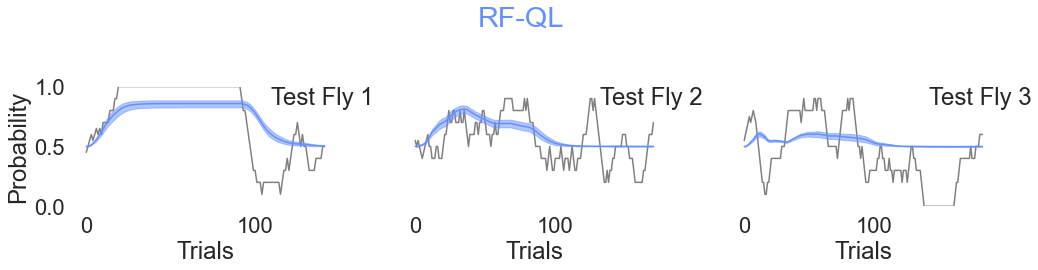

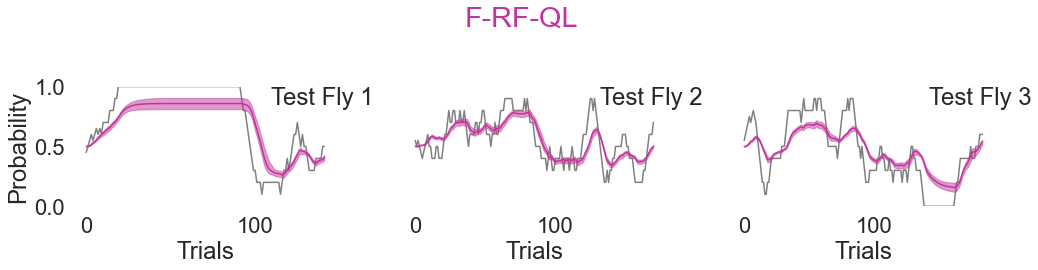

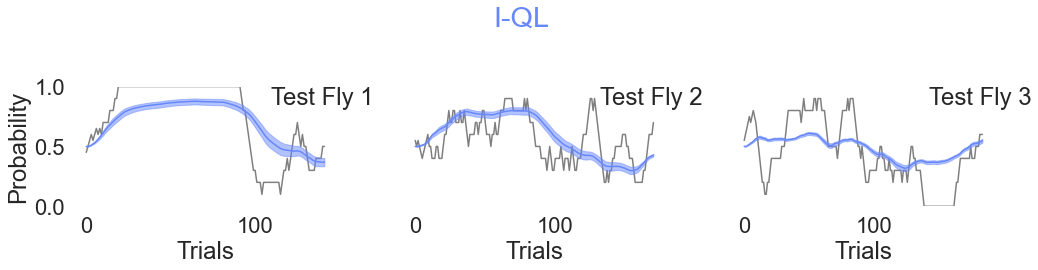

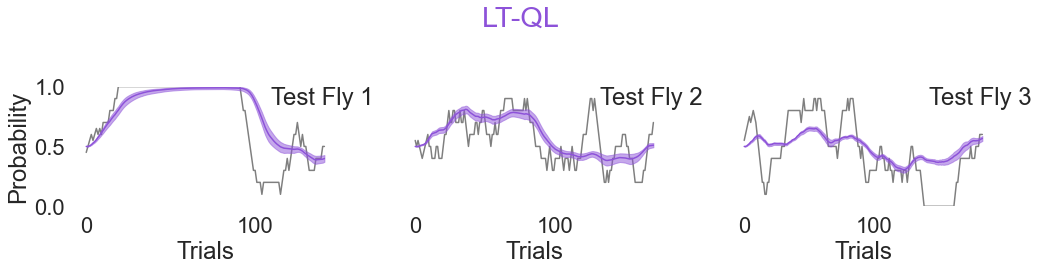

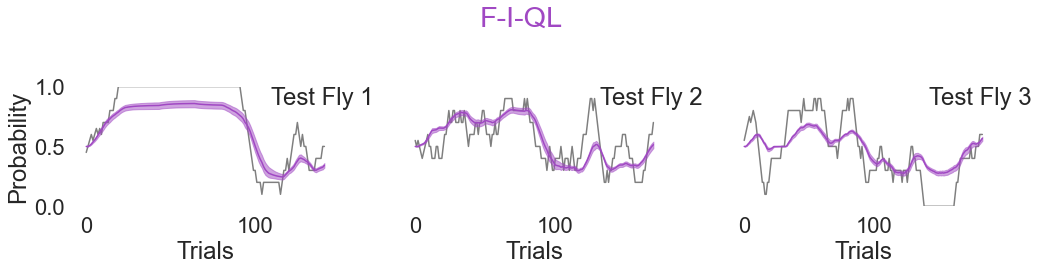

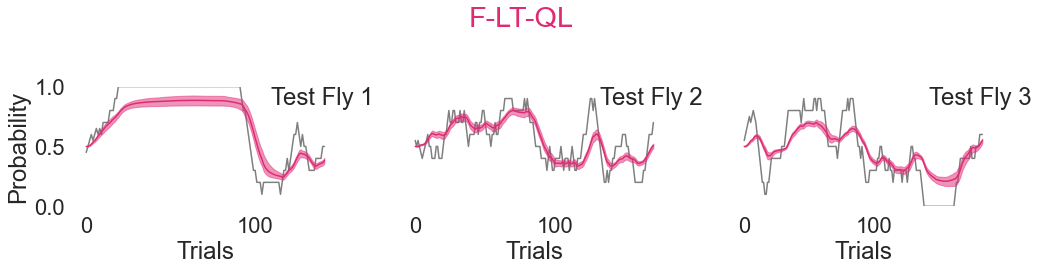

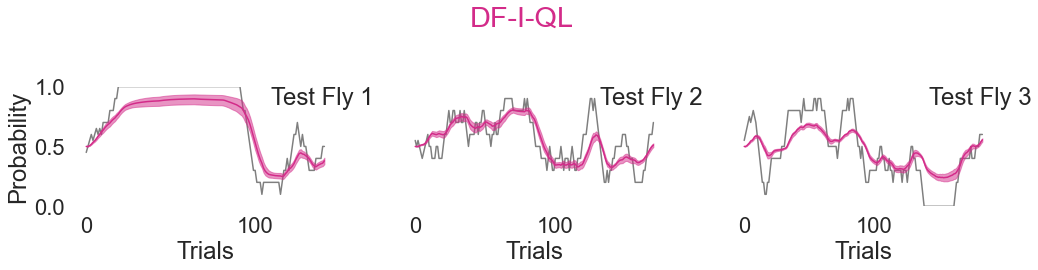

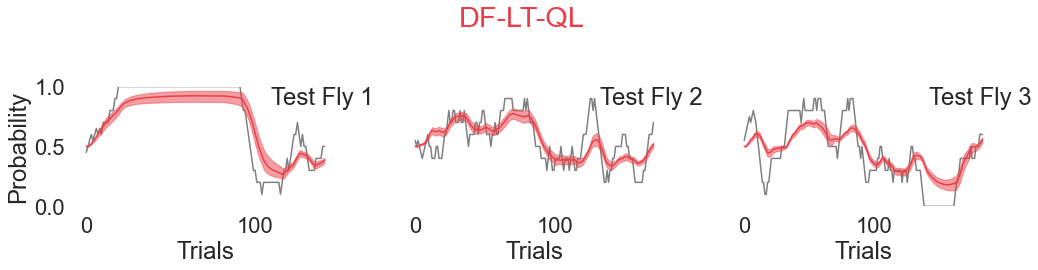

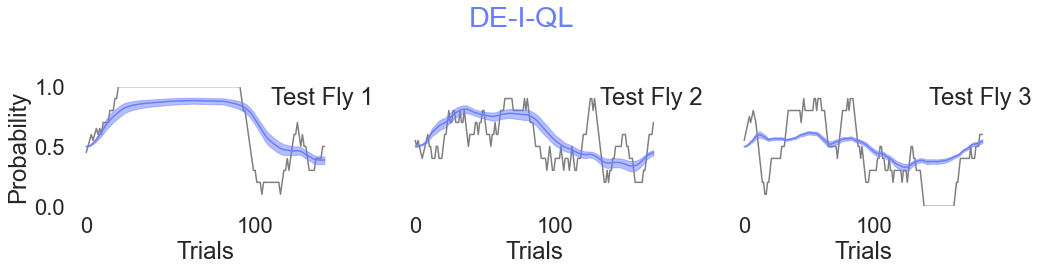

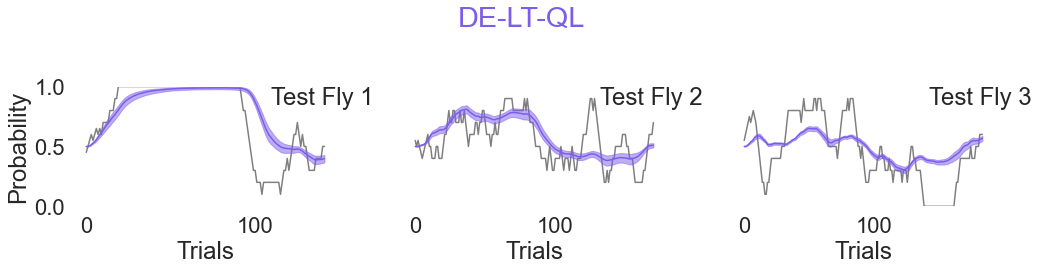

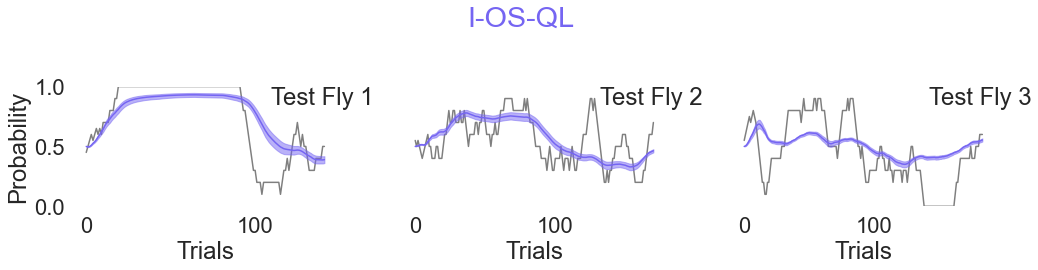

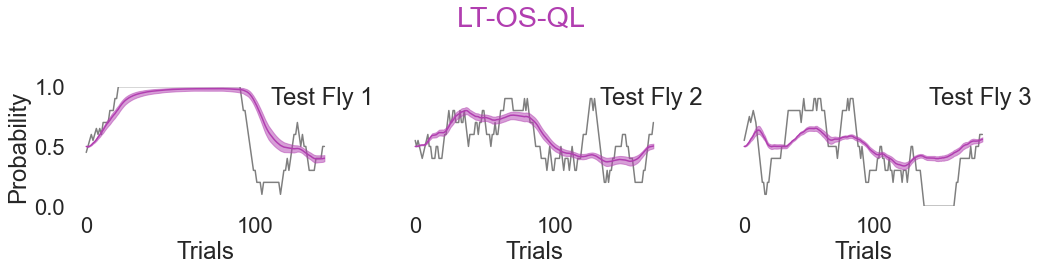

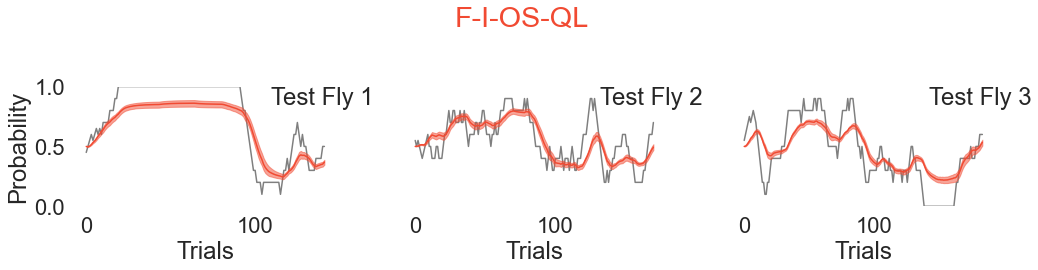

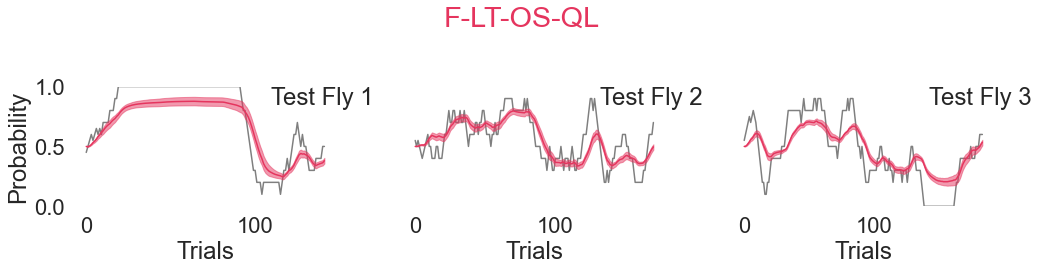

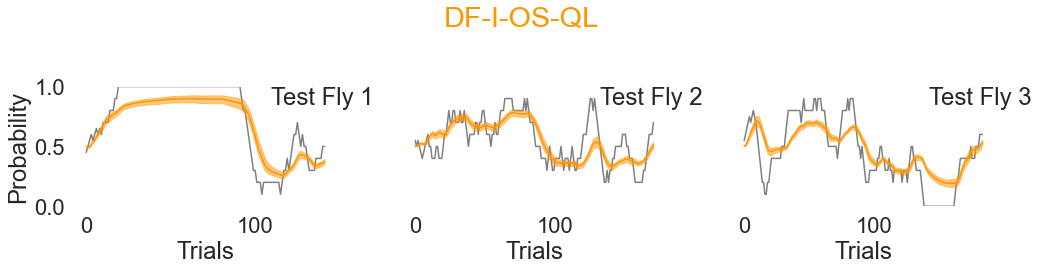

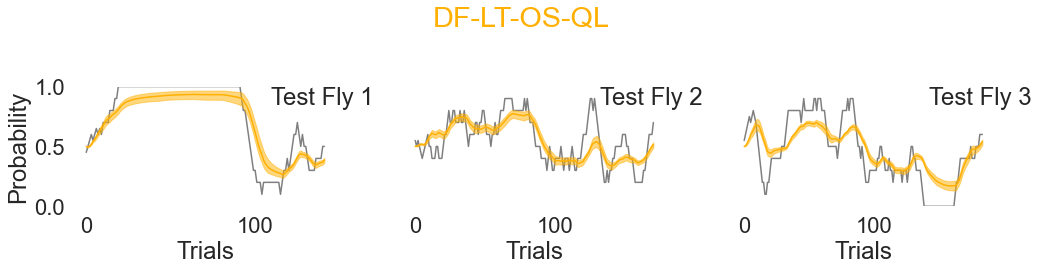

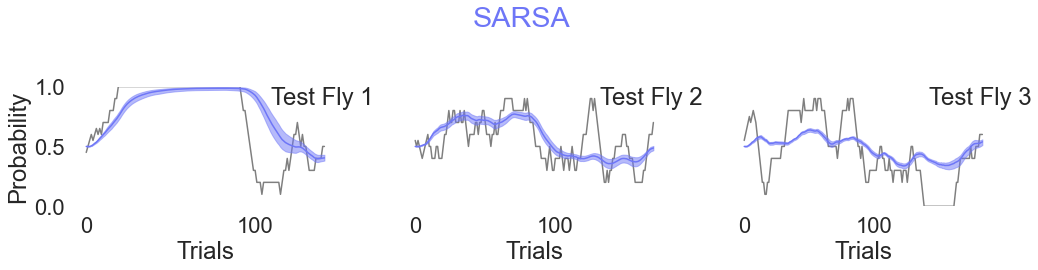

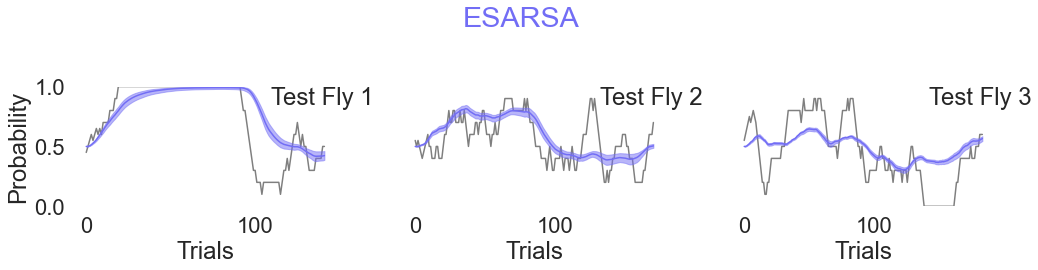

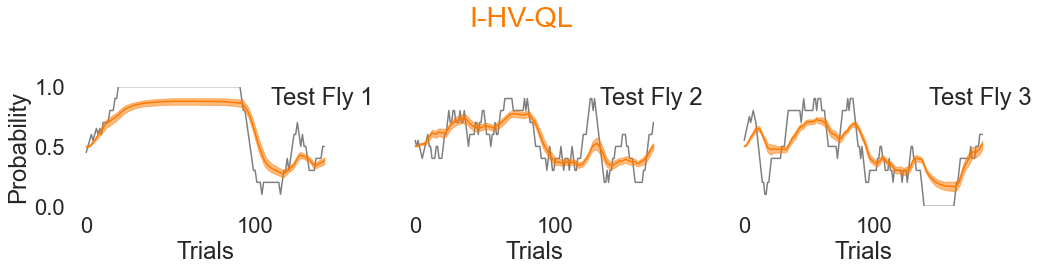

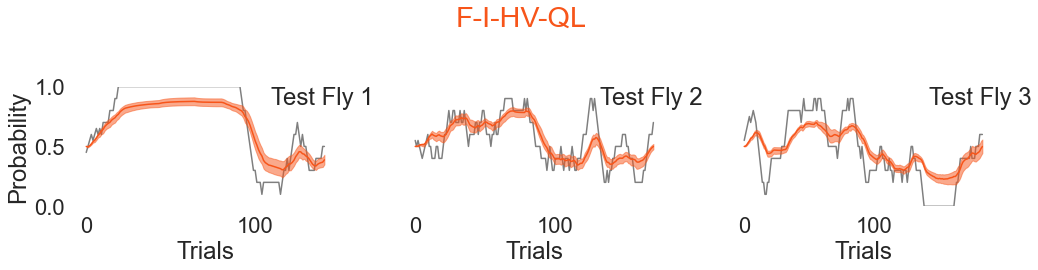

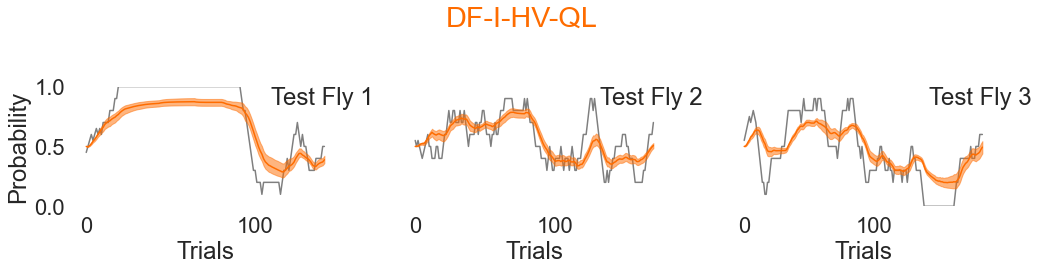

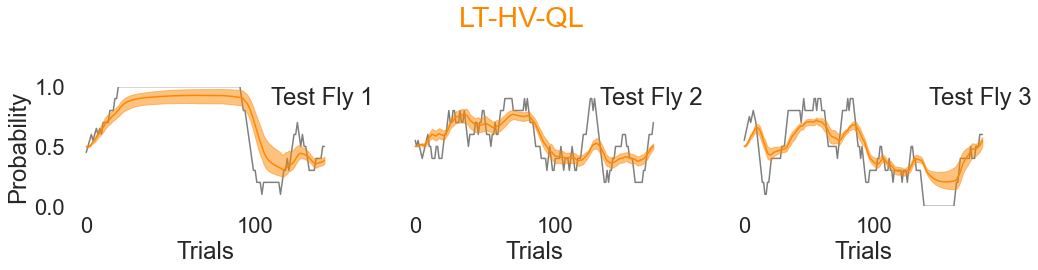

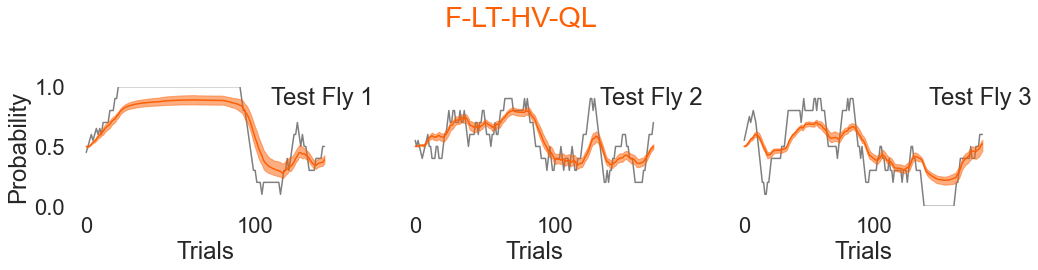

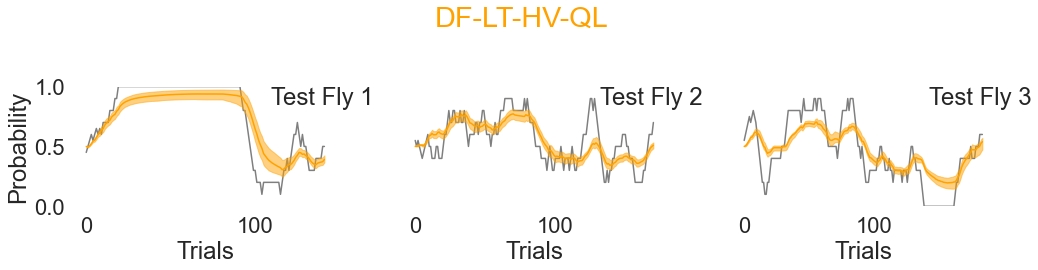

In [15]:
colors = {model:cmap((comparison.Rank.max()-comparison.Rank)/comparison.Rank.max())[i] for i,model in enumerate(comparison['Model'])}

for model in model_classes:
    try:
        model_name = model.__name__
        model_abv = model_simple_abv_map[model_class_name_map[model_name]]

        # get color
        color = colors[model_abv]

        data = np.load(f"data/{model_abv}_probabilities.npz")
        test_probabilities = data['test_probabilities']

        # get true probabilities
        ground_truth = test_choice_set.copy()

        # remove nan
        truth_probabilities = []
        for i in range(ground_truth.shape[0]):
            truth_probabilities.append(ground_truth[i][np.logical_not(np.isnan(ground_truth[i]))])
        truth_probabilities = np.array(truth_probabilities,dtype=object)

        # plot
        history_size = 10

        # apply convolution
        truth_probabilities = smoothen(truth_probabilities,history_size)
        test_probabilities = smoothen(test_probabilities,history_size)
        
        sns.set(style="white",font_scale=2)
        fig, ax = plt.subplots(1,3,figsize=(15,4),sharey=True)
        
        ax[0].plot(np.arange(0,len(truth_probabilities[0])),np.mean(test_probabilities[:,0,:],axis=0)[:len(truth_probabilities[0])] ,color=color)
        ax[0].fill_between(np.arange(0,len(truth_probabilities[0])),np.percentile(test_probabilities[:,0,:],2.5,axis=0)[:len(truth_probabilities[0])],np.percentile(test_probabilities[:,0,:],97.5,axis=0)[:len(truth_probabilities[0])],alpha=0.5,color=color)
        ax[0].plot(np.arange(0,len(truth_probabilities[0])),truth_probabilities[0],color='black',linestyle='-',zorder=-1,alpha=0.5)

        # add text
        ax[0].text(0.75,1.0,f"Test Fly 1",transform=ax[0].transAxes,verticalalignment='top',horizontalalignment='left')

        ax[1].plot(np.arange(0,len(truth_probabilities[1])),np.mean(test_probabilities[:,1,:],axis=0)[:len(truth_probabilities[1])] ,color=color)
        ax[1].fill_between(np.arange(0,len(truth_probabilities[1])),np.percentile(test_probabilities[:,1,:],2.5,axis=0)[:len(truth_probabilities[1])],np.percentile(test_probabilities[:,1,:],97.5,axis=0)[:len(truth_probabilities[1])],alpha=0.5,color=color)
        ax[1].plot(np.arange(0,len(truth_probabilities[1])),truth_probabilities[1],color='black',linestyle='-',zorder=-1,alpha=0.5)

        # add text
        ax[1].text(0.75,1.0,f"Test Fly 2",transform=ax[1].transAxes,verticalalignment='top',horizontalalignment='left')

        ax[2].plot(np.arange(0,len(truth_probabilities[2])),np.mean(test_probabilities[:,2,:],axis=0)[:len(truth_probabilities[2])] ,color=color)
        ax[2].fill_between(np.arange(0,len(truth_probabilities[2])),np.percentile(test_probabilities[:,2,:],2.5,axis=0)[:len(truth_probabilities[2])],np.percentile(test_probabilities[:,2,:],97.5,axis=0)[:len(truth_probabilities[2])],alpha=0.5,color=color)
        ax[2].plot(np.arange(0,len(truth_probabilities[2])),truth_probabilities[2],color='black',linestyle='-',zorder=-1,alpha=0.5)

        # add text
        ax[2].text(0.75,1.0,f"Test Fly 3",transform=ax[2].transAxes,verticalalignment='top',horizontalalignment='left')

        ax[0].set_ylabel('Probability')
        ax[0].set_xlabel('Trials')
        ax[1].set_xlabel('Trials')
        ax[2].set_xlabel('Trials')
        ax[0].set_ylim([0,1])
        ax[1].set_ylim([0,1])
        ax[2].set_ylim([0,1])

        # turn off spines
        for i in range(3):
            for spine in ax[i].spines.values():
                spine.set_visible(False)

        ax[0].set_yticks([0,0.5,1])

        plt.suptitle(f"{model_abv}",color=color)

        plt.tight_layout()
        plt.savefig(f"figures/{model_abv}_probabilities.pdf",bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(e)
        pass

In [16]:
# combine model barcode and model comparison
combined = pd.merge(comparison, model_barcode, on='Model')
combined = pd.merge(combined, test_nllik, on='Model')
combined['Label'] = combined['Model'] + '  ' + combined['Barcode']
# inverse by rank
combined = combined.sort_values(by=['Rank'], ascending=False)
# save
combined.drop(columns=['Barcode','Label','Weight','dWAIC','dSE','Warning','Scale']).to_csv('tables/q_model_comparison.csv',index=False)
combined.drop(columns=['Barcode','Label','Weight','dWAIC','dSE','Warning','Scale'])

Model  Rank         WAIC      pWAIC         SE         p-val  \
0         RF-QL    23  4737.380875   1.938600  30.130912  1.703287e-14   
1          I-QL    22  4646.981109   2.522011  34.625464  1.137840e-09   
2       DE-I-QL    21  4643.346047   4.065228  34.636552  1.535884e-09   
3         SARSA    20  4582.409061   3.441894  35.704999  1.478923e-06   
4        ESARSA    19  4562.065930   3.705425  36.086800  8.494431e-05   
5       I-OS-QL    18  4558.224345   2.898181  36.634062  1.207584e-03   
6      DE-LT-QL    17  4553.607031   4.356413  36.162305  3.949926e-04   
7         LT-QL    16  4551.504777   3.677735  36.239152  5.721850e-04   
8        F-I-QL    15  4535.540407   2.687789  39.254291  6.540408e-05   
9      LT-OS-QL    14  4534.487899   4.142379  37.086270  1.255984e-02   
10      F-RF-QL    13  4526.066715   3.581427  40.086051  1.079830e-04   
11      DF-I-QL    12  4520.778474   3.456018  39.172610  3.584282e-04   
12      F-LT-QL    11  4517.938555   4.192764  39.880190  1.134610e-04   
13   F-LT-OS-QL    10  4509.503098   4.154265  40.097913  9.421412e-04   
14     DF-LT-QL     9  4508.366247   5.522368  40.081162  2.682072e-04   
15    F-I-OS-QL     8  4507.969856   3.532377  40.062600  1.776949e-03   
16    F-I-HV-QL     7  4504.069453  12.365465  39.843212  4.123350e-02   
17   F-LT-HV-QL     6  4501.679001   9.826689  40.215205  9.012147e-02   
18   DF-I-HV-QL     5  4498.552603   9.153040  40.035603  6.859526e-02   
19      I-HV-QL     4  4493.563856   5.930757  40.239281  1.495969e-01   
20     LT-HV-QL     3  4493.279119  11.564118  39.847593  1.021426e-01   
21   DF-I-OS-QL     2  4487.811474   4.274277  40.404088  3.246844e-01   
22  DF-LT-HV-QL     1  4485.671173   9.771486  40.652012  8.706774e-01   
23  DF-LT-OS-QL     0  4484.173461   5.218600  40.677271           NaN   

   significance  effect_size effect  Test Mean   Test SE  Test p-value  \
0          ****     7.671250    ^^^   0.553579  0.037094      0.179562   
1          ****     6.088766    ^^^   0.566471  0.037163      0.208771   
2          ****     6.040552    ^^^   0.568573  0.038391      0.220813   
3          ****     4.814063    ^^^   0.560864  0.031111      0.298096   
4          ****     3.930004    ^^^   0.566908  0.035165      0.265960   
5            **     3.237083    ^^^   0.569166  0.041201      0.303615   
6           ***     3.543407    ^^^   0.571442  0.038469      0.276170   
7           ***     3.444468    ^^^   0.571388  0.038355      0.304966   
8          ****     3.992414    ^^^   0.577513  0.038763      0.375965   
9             *     2.496012    ^^^   0.570205  0.039564      0.304805   
10          ***     3.871916    ^^^   0.573547  0.034964      0.412234   
11          ***     3.568940    ^^^   0.582328  0.041987      0.837472   
12          ***     3.859841    ^^^   0.581219  0.040468      0.724236   
13          ***     3.307258    ^^^   0.579092  0.039594      0.439294   
14          ***     3.644217    ^^^   0.586889  0.043701           NaN   
15           **     3.125182    ^^^   0.577268  0.038336      0.385508   
16            *     2.041174    ^^^   0.578637  0.038404      0.536861   
17           ns     1.694757    ^^^   0.579489  0.039254      0.556446   
18           ns     1.821076    ^^^   0.579439  0.038303      0.559278   
19           ns     1.440957    ^^^   0.580054  0.039132      0.571585   
20           ns     1.634554    ^^^   0.582552  0.042181      0.862442   
21           ns     0.984877    ^^^   0.581621  0.041483      0.805589   
22           ns     0.162798    neg   0.585072  0.042419      0.879074   
23           ns          NaN    ^^^   0.586156  0.044313      0.928102   

   Test Significance  Test Effect Size Test Effect  
0                 ns          1.171667         ^^^  
1                 ns          1.056444         ^^^  
2                 ns          1.015016         ^^^  
3                 ns          0.804612         ^^^  
4                 ns          0.882543     

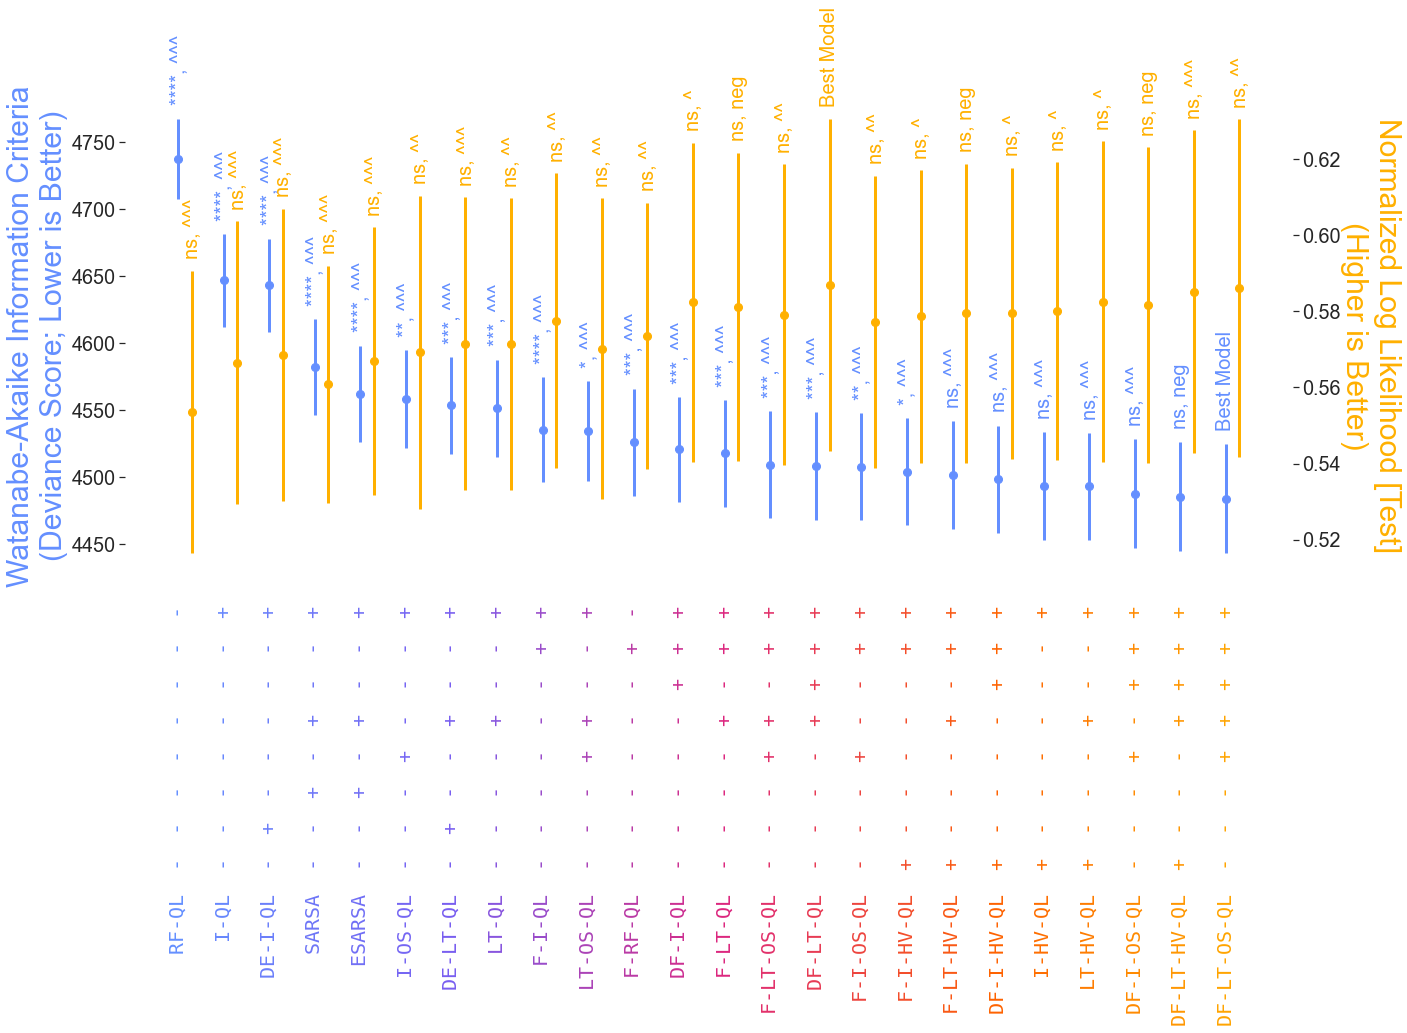

In [17]:
sns.set(style="white", font_scale=1.8)
fig, ax = plt.subplots(figsize=(20,15))

for i in range(len(combined)):
    ax.errorbar(i, combined['WAIC'][i], yerr=combined['SE'][i], fmt='o', color=cmap(0.0), linewidth=3, capthick=3,markersize=8,zorder=10)

    if i != len(combined)-1:
        ax.text(i, combined['WAIC'][i]+combined['SE'][i]+10, combined['significance'][i] + ', '+ combined['effect'][i], ha='center', va='bottom', color=cmap(0.0), fontsize=20, rotation=90)
    else:
        ax.text(i, combined['WAIC'][i]+combined['SE'][i]+10, 'Best Model', ha='center', va='bottom', color=cmap(0.0), fontsize=20, rotation=90)
    
    # add x tick label manually
    ax.text(i, np.min(combined['WAIC'])-80, combined['Label'][i], ha='center', va='top', color=cmap(i/len(combined)), fontsize=20, rotation=90, fontname='monospace')

# ax.set_xticks(np.arange(len(combined)), combined['Label'], rotation=90, ha='center', fontname='monospace')
ax.set_xticks([])

ax.set_ylabel('Watanabe-Akaike Information Criteria\n(Deviance Score; Lower is Better)', color=cmap(0.0), fontsize=30)

# add twin y axis
ax2 = ax.twinx()

for i in range(len(combined)):
    ax2.errorbar(i+0.3, combined['Test Mean'][i], yerr=combined['Test SE'][i], fmt='o', color=cmap(1.0), linewidth=3, capthick=3,markersize=8,zorder=5)

    if i != combined['Test Mean'].idxmax():
        ax2.text(i+0.3, combined['Test Mean'][i]+combined['Test SE'][i]+0.003, combined['Test Significance'][i] + ', '+ combined['Test Effect'][i], ha='center', va='bottom', color=cmap(1.0), fontsize=20, rotation=90)
    else:
        ax2.text(i+0.3, combined['Test Mean'][i]+combined['Test SE'][i]+0.003, 'Best Model', ha='center', va='bottom', color=cmap(1.0), fontsize=20, rotation=90)
        

ax2.set_ylabel('Normalized Likelihood [Test]\n(Higher is Better)', color=cmap(1.0), rotation=-90, labelpad=60, fontsize=30)

# remove all spines
for spine in ax.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("figures/AcceptReject_comparison_full.pdf",bbox_inches='tight')
plt.show()

In [18]:
def name_cleaner(x):
    """
    convert to lowercase and replace special characters
    """
    return x.lower().replace(' ','_').replace('-','_')

cognitive_features = model_database.groupby(['ModelAbv']).aggregate({i:'first' for i in model_database.columns[-8:]}).reset_index().replace({'+':1,'-':0})
cognitive_features.columns = [name_cleaner(i) for i in cognitive_features.columns]
cognitive_features = cognitive_features.rename(columns={'modelabv':'model'})

dfs = []
for m in model_fits.keys():
    data_vars = model_fits[m]['posterior'].data_vars.keys()
    df = {}
    for v in data_vars:
        df[v] = model_fits[m]['posterior'][v].values.flatten()
    df = pd.DataFrame(df)
    df['model'] = model_simple_abv_map[m]
    dfs.append(df)
param_posteriors = pd.concat(dfs)

# combine cognitive features and parameter posteriors
full_anova_dataset = pd.merge(cognitive_features, param_posteriors, on='model')

In [19]:
def pvalue_to_stars_(pvalue):
    if pvalue < 0.0001:
        return '(p < 0.0001)'
    elif pvalue < 0.001:
        return f'(p={pvalue:.4f})'
    elif pvalue < 0.01:
        return f'(p={pvalue:.3f})'
    elif pvalue > 0.05:
        return f'(p={pvalue:.2f})'
    else:
        return ''

all_results = []
for dep_var in tqdm(param_posteriors.drop(columns=['model']).columns):
    # filter out nan values for dependent variable
    anova_dataset = full_anova_dataset[~np.isnan(full_anova_dataset[dep_var])].copy()
    # drop all columns that are not cognitive features or dependent variable
    anova_dataset = anova_dataset.drop(columns=[i for i in anova_dataset.columns if i not in cognitive_features.drop(columns=['model']).columns and i != dep_var]).reset_index(drop=True)
    # drop all columns that are all 0 or all 1
    # anova_dataset = anova_dataset.drop(columns=[i for i in anova_dataset.columns if np.all(anova_dataset[i]==0) or np.all(anova_dataset[i]==1)]).reset_index(drop=True)
    # create formula
    formula = dep_var + ' ~ ' + ' + '.join(["C(" + i + ")" for i in anova_dataset.drop(columns=[dep_var]).columns])
    # run anova
    import statsmodels.api as sm
    model = sm.OLS.from_formula(formula, data=anova_dataset)
    results = model.fit()
    from statsmodels.stats.anova import anova_lm
    anova_results = anova_lm(results)
    # get p values
    p_values = [pvalue_to_stars_(v) for v in anova_results['PR(>F)'].values]
    # calculate effect size
    effect_sizes = (anova_results['sum_sq']/sum(anova_results['sum_sq'])).values
    # join p values and effect sizes
    column_names = list(anova_dataset.drop(columns=[dep_var]).columns) + ['residual']
    results = {column_names[i] : '{:0.2f} {}'.format(effect_sizes[i], p_values[i]) for i in range(len(effect_sizes))}
    results['parameter'] = dep_var
    results = pd.DataFrame(results, index=[0])
    all_results.append(results)

  0%|          | 0/15 [00:00<?, ?it/s]

In [20]:
anova_data = pd.concat(all_results).set_index('parameter').T
anova_data = anova_data.replace({'0.00 ': '-'})
anova_data.to_csv('tables/anova_results.csv')
anova_data

parameter                                    weight          intercept  \
rpe                               0.27 (p < 0.0001)  0.15 (p < 0.0001)   
forgetting                        0.03 (p < 0.0001)  0.39 (p < 0.0001)   
learning_forgetting_independence  0.00 (p < 0.0001)  0.01 (p < 0.0001)   
discounting                       0.32 (p < 0.0001)  0.07 (p < 0.0001)   
omission_sensitivity              0.01 (p < 0.0001)  0.01 (p < 0.0001)   
on_policy                         0.02 (p < 0.0001)  0.02 (p < 0.0001)   
learning_extinction_independence  0.03 (p < 0.0001)  0.01 (p < 0.0001)   
ape                               0.08 (p < 0.0001)  0.00 (p < 0.0001)   
residual                                      0.24               0.34    

parameter                                     alpha              gamma  \
rpe                               0.57 (p < 0.0001)                  -   
forgetting                        0.03 (p < 0.0001)  0.35 (p < 0.0001)   
learning_forgetting_independence  0.03 (p < 0.0001)  0.11 (p < 0.0001)   
discounting                       0.06 (p < 0.0001)                  -   
omission_sensitivity              0.01 (p < 0.0001)  0.14 (p < 0.0001)   
on_policy                           0.00 (p=0.0007)  0.01 (p < 0.0001)   
learning_extinction_independence  0.00 (p < 0.0001)  0.00 (p < 0.0001)   
ape                                               -  0.05 (p < 0.0001)   
residual                                      0.31               0.34    

parameter                                       tau              kappa  \
rpe                                               -                  -   
forgetting                                        -                  -   
learning_forgetting_independence                  -                  -   
discounting                       0.92 (p < 0.0001)  0.27 (p < 0.0001)   
omission_sensitivity                              -  0.39 (p < 0.0001)   
on_policy                                         -                  -   
learning_extinction_independence                  -                  -   
ape                                               -                  -   
residual                                      0.08               0.34    

parameter                                  weight_r           weight_h  \
rpe                                               -                  -   
forgetting                        0.05 (p < 0.0001)  0.46 (p < 0.0001)   
learning_forgetting_independence  0.01 (p < 0.0001)  0.04 (p < 0.0001)   
discounting                       0.03 (p < 0.0001)  0.05 (p < 0.0001)   
omission_sensitivity                              -                  -   
on_policy                                         -                  -   
learning_extinction_independence                  -                  -   
ape                                               -                  -   
residual                                      0.92               0.45    

parameter                                  weight_b            alpha_r  \
rpe                                               -                  -   
forgetting                        0.00 (p < 0.0001)  0.03 (p < 0.0001)   
learning_forgetting_independence  0.00 (p < 0.0001)  0.10 (p < 0.0001)   
discounting                       0.05 (p < 0.0001)  0.21 (p < 0.0001)   
omission_sensitivity                              -                  -   
on_policy                                         -                  -   
learning_extinction_independence                  -                  -   
ape                                               -                  -   
residual                                      0.95               0.66    

parameter                                   kappa_r            alpha_h  \
rpe                                               -                  -   
forgetting                                        -  0.13 (p < 0.0001)   
learning_forgetting_independence                  -  0.00 (p < 0.0001)   

In [21]:
# Load Training Data
training_choice_set = np.loadtxt('../../../FlYMazeRL/data/rajagopalan2022/training_choice_set.csv', delimiter=',')
training_reward_set = np.loadtxt('../../../FlYMazeRL/data/rajagopalan2022/training_reward_set.csv', delimiter=',')
# Load Test Data
test_choice_set = np.loadtxt('../../../FlYMazeRL/data/rajagopalan2022/test_choice_set.csv', delimiter=',')
test_reward_set = np.loadtxt('../../../FlYMazeRL/data/rajagopalan2022/test_reward_set.csv', delimiter=',')

In [22]:
model_classes = [eval(x) for x in model_class_name_map.keys()]

  0%|          | 0/1000 [00:00<?, ?it/s]

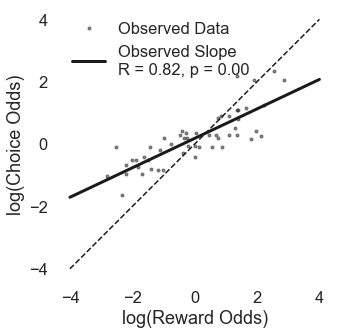

1/24: RewardLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

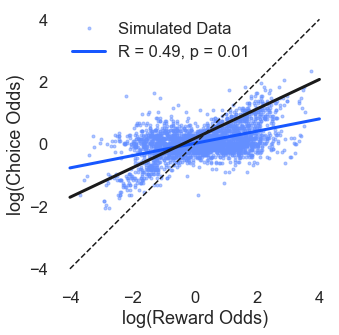

2/24: ForgettingRewardLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

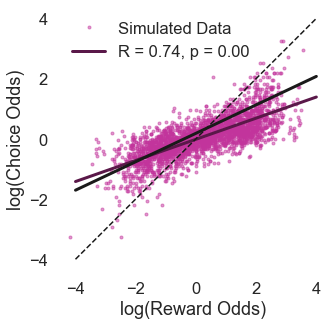

3/24: IQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

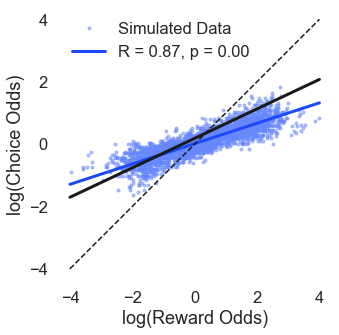

4/24: CQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

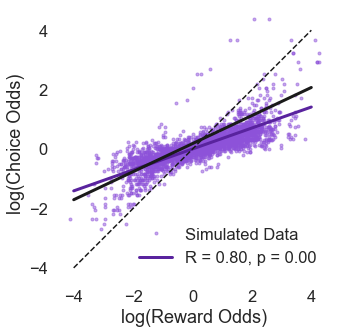

5/24: FQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

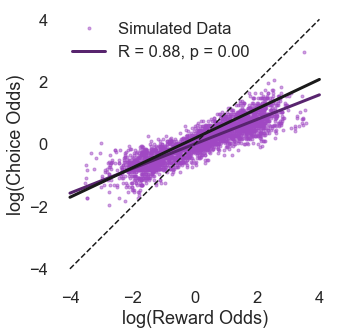

6/24: FCQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

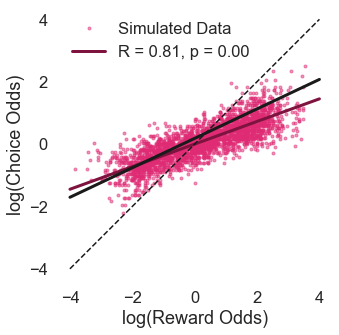

7/24: DFQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

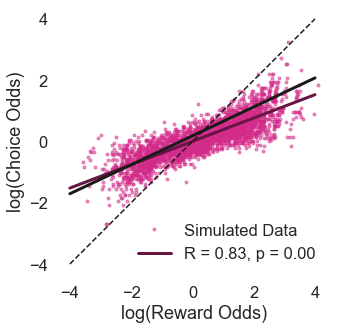

8/24: DFCQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

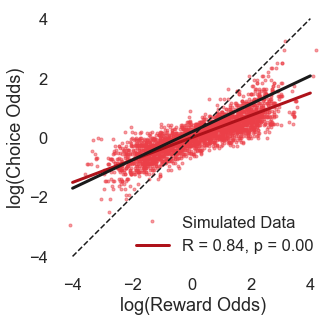

9/24: DEQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

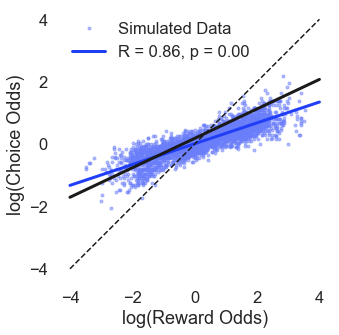

10/24: DECQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

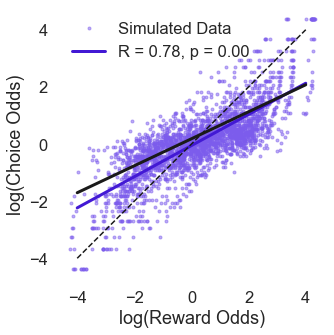

11/24: OSQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

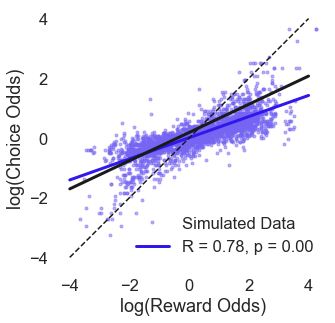

12/24: OSCQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

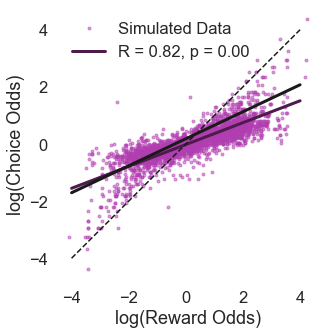

13/24: FOSQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

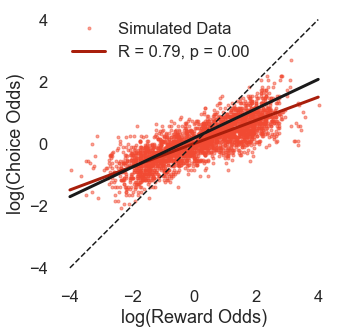

14/24: FOSCQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

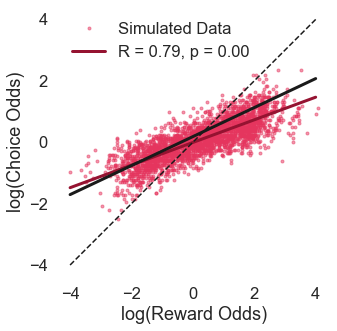

15/24: DFOSQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

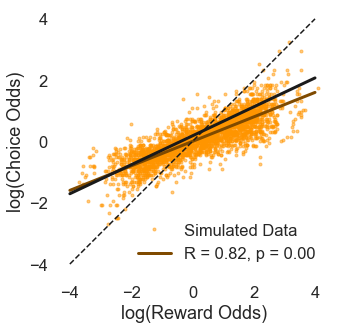

16/24: DFOSCQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

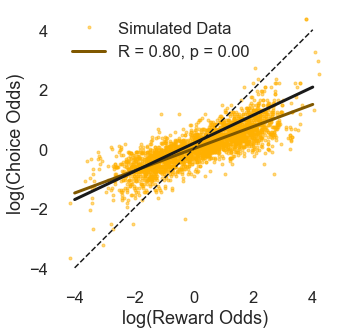

17/24: SARSALearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

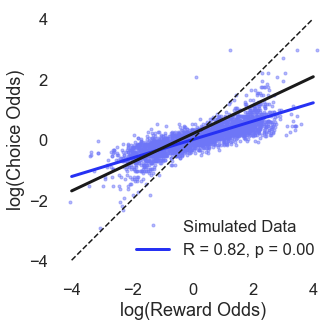

18/24: ESARSALearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

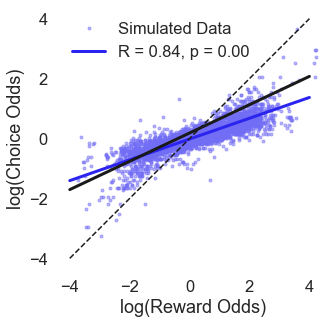

19/24: HQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

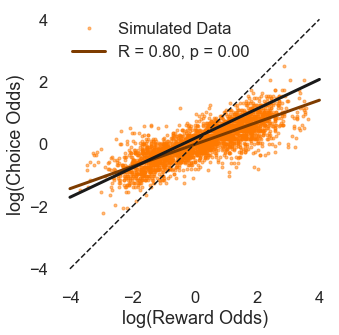

20/24: FHQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

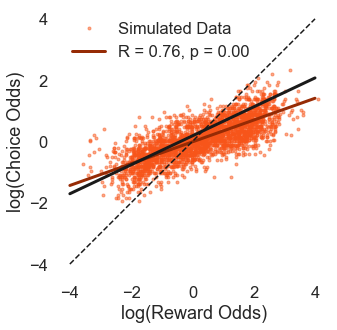

21/24: DFHQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

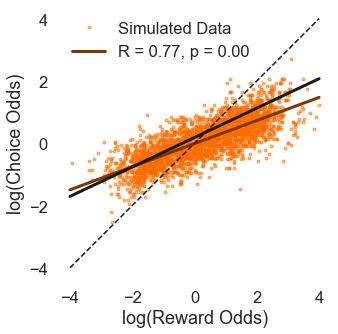

22/24: HCQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

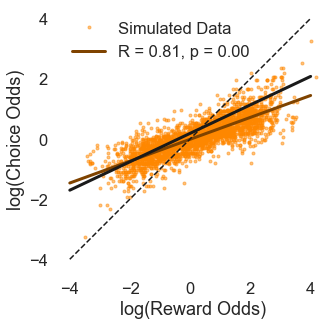

23/24: FHCQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

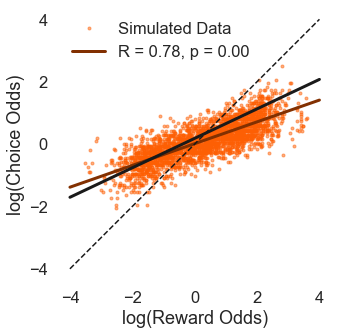

24/24: DFHCQLearner_acceptreject


  0%|          | 0/1000 [00:00<?, ?it/s]

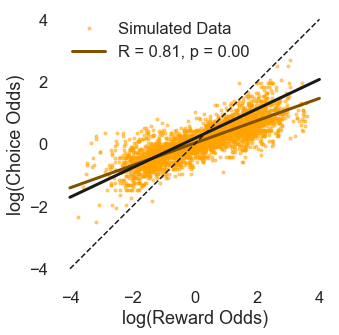

In [23]:
# matching coomparison

matching_data = {}

generalized_matching_law = True
overwrite = False

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(5,5))

choice_ratios = []
reward_ratios = []
for fly in range(len(training_choice_set)):
    for trial in range(80,len(training_choice_set[fly])+41,80):
        choice_sample = training_choice_set[fly, trial-80:trial]
        reward_sample = training_reward_set[fly, trial-80:trial]

        if generalized_matching_law:
            choice_ratio = np.log(np.sum(choice_sample==0))-np.log(np.sum(choice_sample==1))
            reward_ratio = np.log(np.sum(np.logical_and(choice_sample==0,reward_sample==1)))-np.log(np.sum(np.logical_and(choice_sample==1,reward_sample==1)))
        else:
            choice_ratio = np.sum(choice_sample==0)/(np.sum(choice_sample==1)+np.sum(choice_sample==0))
            reward_ratio = np.sum(np.logical_and(choice_sample==0,reward_sample==1))/(np.sum(np.logical_and(choice_sample==0,reward_sample==1))+np.sum(np.logical_and(choice_sample==1,reward_sample==1)))

        choice_ratios.append(choice_ratio)
        reward_ratios.append(reward_ratio)

choice_ratios = np.array(choice_ratios)
reward_ratios = np.array(reward_ratios)

acceptable_indices = np.logical_and(np.logical_and(np.isnan(choice_ratios)==False,np.isnan(reward_ratios)==False),np.logical_and(np.isinf(choice_ratios)==False,np.isinf(reward_ratios)==False))
choice_ratios = choice_ratios[acceptable_indices]
reward_ratios = reward_ratios[acceptable_indices]
plt.plot(reward_ratios,choice_ratios,'.',alpha=0.5,color='k',label='Observed Data')

n_bootstraps = 1000
bootstrapped_linear_fit = []
for i in tqdm(range(n_bootstraps)):
    bootstrap_indices = np.random.choice(np.arange(len(choice_ratios)),len(choice_ratios),replace=True)
    bootstrap_choice_ratios = choice_ratios[bootstrap_indices]
    bootstrap_reward_ratios = reward_ratios[bootstrap_indices]

    slope_t, intercept_t, r_value, p_value, std_err = stats.linregress(bootstrap_reward_ratios,bootstrap_choice_ratios)
    bootstrapped_linear_fit.append([slope_t, intercept_t, r_value, p_value, std_err])

bootstrapped_linear_fit = pd.DataFrame(bootstrapped_linear_fit,columns=['Slope','Intercept','R','P','SE'])

matching_data['Observed'] = bootstrapped_linear_fit

x_data = np.linspace(-4,4,100)
y_data = bootstrapped_linear_fit['Slope'].mean()*x_data + bootstrapped_linear_fit['Intercept'].mean()
plt.plot(x_data,y_data,'-',color='k',linewidth=3,label='Observed Slope\nR = %.2f, p = %.2f' % (bootstrapped_linear_fit['R'].mean(),bootstrapped_linear_fit['P'].mean()))

if generalized_matching_law:
    plt.xlabel('log(Reward Odds)')
    plt.ylabel('log(Choice Odds)')
else:
    plt.xlabel(r'Reward Ratio ($\frac{R_{1}}{R_{1}+R_{2}}$)')
    plt.ylabel(r'Choice Ratio ($\frac{C_{1}}{C_{1}+C_{2}}$)')
plt.plot(x_data,x_data,'k--')
plt.gca().set_aspect('equal', adjustable='box')
plt.box(False)
plt.tight_layout()
plt.legend(frameon=False,loc='upper left')
plt.savefig("figures/Matching_DATA.pdf",bbox_inches='tight')
plt.show()

n_samples = 18
repeats = 50
n_blocks = 3
size_block = 80

for model_no,model in enumerate(model_classes):
    model_name = model.__name__
    print(str(model_no+1) + "/" + str(len(model_classes)) + ": " + model_name)
    model_abv = model_simple_abv_map[model_class_name_map[model_name]]
    color = cmap((combined['Rank'].max()-combined[combined['Model']==model_abv]['Rank'].values)/combined['Rank'].max())
    if len(color)==0:
        color = cmap(0.5)

    if (not os.path.exists('data/matching_data_' + model_abv + '.npz')) or overwrite:
        try:
            params, policy_params = generate_params_from_fits(agentClass=model,n_samples=n_samples,sample_from_population=True)
        except:
            print("Failed to generate params from fits")
            continue
        
        choice_set = []
        reward_set = []
        for r in tqdm(range(repeats)):
            for i in range(n_samples):
                log = pd.read_csv('../../../FlYMazeRL/data/rajagopalan2022/train_log.csv')
                p_vals = log.loc[i,'p1':'p4']
                sum = log.loc[i,'sum']
                if r==0 and model_no==0:
                    print(p_vals.values,sum)
                env = ymaze_baiting(n_trials_per_session=size_block*n_blocks, n_trial_per_blocks = [size_block]*n_blocks, baiting_probabilities=[[p_vals[k],sum-p_vals[k]] for k in range(n_blocks)])
                agent = model(env, params[i], policy_params[i])
                agent.next_episode()
                choice_set.append(agent.action_history)
                reward_set.append(agent.reward_history)
        
        choice_set = np.array(choice_set)
        reward_set = np.array(reward_set)
        np.savez_compressed('data/matching_data_' + model_abv + '.npz',choice_set=choice_set,reward_set=reward_set)
    else:
        data = np.load('data/matching_data_' + model_abv + '.npz')
        choice_set = data['choice_set']
        reward_set = data['reward_set']

    sns.set(font_scale=1.5)
    fig, ax = plt.subplots(figsize=(5,5))
    
    choice_ratios = []
    reward_ratios = []
    for fly in range(len(choice_set)):
        for trial in range(80,len(choice_set[fly])+41,80):
            choice_sample = choice_set[fly, trial-80:trial]
            reward_sample = reward_set[fly, trial-80:trial]

            if generalized_matching_law:
                choice_ratio = np.log(np.sum(choice_sample==0))-np.log(np.sum(choice_sample==1))
                reward_ratio = np.log(np.sum(np.logical_and(choice_sample==0,reward_sample==1)))-np.log(np.sum(np.logical_and(choice_sample==1,reward_sample==1)))
            else:
                choice_ratio = np.sum(choice_sample==0)/(np.sum(choice_sample==1)+np.sum(choice_sample==0))
                reward_ratio = np.sum(np.logical_and(choice_sample==0,reward_sample==1))/(np.sum(np.logical_and(choice_sample==0,reward_sample==1))+np.sum(np.logical_and(choice_sample==1,reward_sample==1)))


            choice_ratios.append(choice_ratio)
            reward_ratios.append(reward_ratio)

    choice_ratios = np.array(choice_ratios)
    reward_ratios = np.array(reward_ratios)

    acceptable_indices = np.logical_and(np.logical_and(np.isnan(choice_ratios)==False,np.isnan(reward_ratios)==False),np.logical_and(np.isinf(choice_ratios)==False,np.isinf(reward_ratios)==False))
    choice_ratios = choice_ratios[acceptable_indices]
    reward_ratios = reward_ratios[acceptable_indices]
    plt.plot(reward_ratios,choice_ratios,'.',alpha=0.5,label='Simulated Data',color=color)

    n_bootstraps = 1000
    bootstrapped_linear_fit = []
    for i in tqdm(range(n_bootstraps)):
        bootstrap_indices = np.random.choice(np.arange(len(choice_ratios)),len(choice_ratios)//repeats,replace=True)
        bootstrap_choice_ratios = choice_ratios[bootstrap_indices]
        bootstrap_reward_ratios = reward_ratios[bootstrap_indices]

        slope_t, intercept_t, r_value, p_value, std_err = stats.linregress(bootstrap_reward_ratios,bootstrap_choice_ratios)
        bootstrapped_linear_fit.append([slope_t, intercept_t, r_value, p_value, std_err])

    bootstrapped_linear_fit = pd.DataFrame(bootstrapped_linear_fit,columns=['Slope','Intercept','R','P','SE'])

    matching_data[model_abv] = bootstrapped_linear_fit

    x = np.linspace(-4,4,100)
    y = bootstrapped_linear_fit['Slope'].mean()*x + bootstrapped_linear_fit['Intercept'].mean()
    plt.plot(x,y,'-',color=change_lightness(color,1.5), \
            linewidth=3,label='R = %.2f, p = %.2f' % (bootstrapped_linear_fit['R'].mean(),bootstrapped_linear_fit['P'].mean()))
    plt.plot(x_data,y_data,'-',color='k',linewidth=3)
    
    if generalized_matching_law:
        plt.xlabel('log(Reward Odds)')
        plt.ylabel('log(Choice Odds)')
    else:
        plt.xlabel(r'Reward Ratio ($\frac{R_{1}}{R_{1}+R_{2}}$)')
        plt.ylabel(r'Choice Ratio ($\frac{C_{1}}{C_{1}+C_{2}}$)')
    plt.plot(x,x,'k--')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.box(False)
    plt.tight_layout()
    plt.legend(frameon=False)
    plt.savefig(f"figures/Matching_{model_abv}.pdf",bbox_inches='tight')
    plt.show()


In [24]:
# make into a dataframe
matching_data = pd.concat(matching_data).reset_index()
matching_data = matching_data.rename(columns={'level_0':'Model','level_1':'Bootstrap'})
if generalized_matching_law:
    # rename the slope and intercept
    matching_data.columns = ['Model','Bootstrap','Matching Strength','Bias','R','P','SE']
# save
matching_data.to_csv('data/matching_data.csv',index=False)

In [25]:
# load data
matching_data = pd.read_csv('data/matching_data.csv')
matching_data.head()

Model  Bootstrap  Matching Strength      Bias         R             P  \
0  Observed          0           0.476555  0.216890  0.850147  1.546712e-15   
1  Observed          1           0.479284  0.286607  0.851523  1.249368e-15   
2  Observed          2           0.425801  0.165196  0.798777  1.287115e-12   
3  Observed          3           0.487848  0.179360  0.863488  1.772813e-16   
4  Observed          4           0.549837  0.228664  0.816542  1.598636e-13   

         SE  
0  0.041742  
1  0.041735  
2  0.045355  
3  0.040299  
4  0.054974

In [26]:
# compare significance of observed data with model data using mann-whitney u test

if generalized_matching_law:
    matching_strength_sig = {}
    bias_sig = {}
    matching_strength_effect = {}
    bias_effect = {}
else:
    slope_sig = {}
    intercept_sig = {}
    slope_effect = {}
    intercept_effect = {}

subsample = 18
n_subsample = 1000

obs = matching_data[matching_data['Model']=='Observed']
for model in tqdm(matching_data['Model'].unique()):
    if model=='Observed':
        continue

    mod = matching_data[matching_data['Model']==model]
    
    if generalized_matching_law:
        matching_strength_sig[model] = []
        bias_sig[model] = []
    else:
        slope_sig[model] = []
        intercept_sig[model] = []

    for i in range(n_subsample):
        obs_sub = obs.sample(subsample)
        mod_sub = mod.sample(subsample)
        if generalized_matching_law:
            matching_strength_sig[model].append(stats.mannwhitneyu(obs_sub['Matching Strength'],mod_sub['Matching Strength'])[1])
            bias_sig[model].append(stats.mannwhitneyu(obs_sub['Bias'],mod_sub['Bias'])[1])
        else:
            slope_sig[model].append(stats.mannwhitneyu(obs_sub['Slope'],mod_sub['Slope'])[1])
            intercept_sig[model].append(stats.mannwhitneyu(obs_sub['Intercept'],mod_sub['Intercept'])[1])
    
    # get the 95th percentile of the p-values
    if generalized_matching_law:
        matching_strength_sig[model] = np.quantile(matching_strength_sig[model],0.95)
        bias_sig[model] = np.quantile(bias_sig[model],0.95)
    else:
        slope_sig[model] = np.quantile(slope_sig[model],0.95)
        intercept_sig[model] = np.quantile(intercept_sig[model],0.95)
    
    if generalized_matching_law:
        matching_strength_effect[model] = cliffsDelta(obs['Matching Strength'].values,mod['Matching Strength'].values)
        bias_effect[model] = cliffsDelta(obs['Bias'].values,mod['Bias'].values)
    else:
        slope_effect[model] = cliffsDelta(obs['Slope'].values,mod['Slope'].values)
        intercept_effect[model] = cliffsDelta(obs['Intercept'].values,mod['Intercept'].values)
        

if generalized_matching_law:
    matching_strength_sig = pd.DataFrame.from_dict(matching_strength_sig,orient='index',columns=['p-value'])
    bias_sig = pd.DataFrame.from_dict(bias_sig,orient='index',columns=['p-value'])
    matching_strength_effect = pd.DataFrame.from_dict(matching_strength_effect,orient='index',columns=['Effect Size'])
    bias_effect = pd.DataFrame.from_dict(bias_effect,orient='index',columns=['Effect Size'])
else:
    slope_sig = pd.DataFrame.from_dict(slope_sig,orient='index',columns=['p-value'])
    intercept_sig = pd.DataFrame.from_dict(intercept_sig,orient='index',columns=['p-value'])
    slope_effect = pd.DataFrame.from_dict(slope_effect,orient='index',columns=['Effect Size'])
    intercept_effect = pd.DataFrame.from_dict(intercept_effect,orient='index',columns=['Effect Size'])

# convert p-values to significance
if generalized_matching_law:
    matching_strength_sig['Significance'] = matching_strength_sig['p-value'].apply(pvalue_to_stars)
    bias_sig['Significance'] = bias_sig['p-value'].apply(pvalue_to_stars)
    matching_strength_effect['Effect'] = matching_strength_effect['Effect Size'].apply(delta_to_effect)
    bias_effect['Effect'] = bias_effect['Effect Size'].apply(delta_to_effect)
else:
    slope_sig['Significance'] = slope_sig['p-value'].apply(pvalue_to_stars)
    intercept_sig['Significance'] = intercept_sig['p-value'].apply(pvalue_to_stars)
    slope_effect['Effect'] = slope_effect['Effect Size'].apply(delta_to_effect)
    intercept_effect['Effect'] = intercept_effect['Effect Size'].apply(delta_to_effect)
    
    

  0%|          | 0/25 [00:00<?, ?it/s]

In [61]:
# merge the dataframes
if generalized_matching_law:
    matching_significance = matching_strength_sig.merge(bias_sig,left_index=True,right_index=True)
    matching_significance = matching_significance.merge(matching_strength_effect,left_index=True,right_index=True)
    matching_significance = matching_significance.merge(bias_effect,left_index=True,right_index=True)
    matching_significance = matching_significance.rename(columns={'p-value_x':'Matching Strength p-value','p-value_y':'Bias p-value','Effect Size_x':'Matching Strength Effect Size','Effect Size_y':'Bias Effect Size'})
    matching_significance = matching_significance[['Matching Strength p-value','Matching Strength Effect Size','Bias p-value','Bias Effect Size']]
else:
    matching_significance = slope_sig.merge(intercept_sig,left_index=True,right_index=True)
    matching_significance = matching_significance.merge(slope_effect,left_index=True,right_index=True)
    matching_significance = matching_significance.merge(intercept_effect,left_index=True,right_index=True)
    matching_significance = matching_significance.rename(columns={'p-value_x':'Slope p-value','p-value_y':'Intercept p-value','Effect Size_x':'Slope Effect Size','Effect Size_y':'Intercept Effect Size'})
    matching_significance = matching_significance[['Slope p-value','Slope Effect Size','Intercept p-value','Intercept Effect Size']]

# save the data
matching_significance.to_csv('tables/matching_significance.csv')

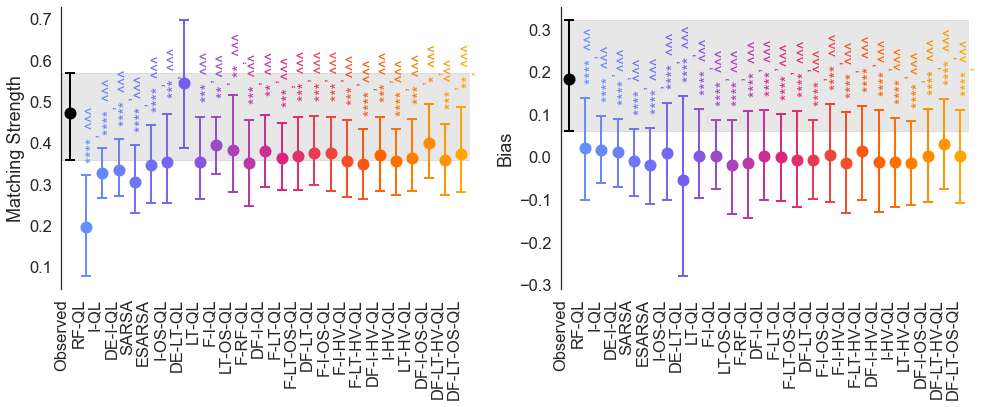

In [27]:

sns.set(font_scale=1.5,style='white')
fig, ax = plt.subplots(1,2,figsize=(14,6))

var1 = 'Matching Strength' if generalized_matching_law else 'Slope'
var2 = 'Bias' if generalized_matching_law else 'Intercept'

# plot slope on top
order = ["Observed"]+list(comparison.Model.values)
colors = [(0.,0.,0.)]+[cmap(model_no/len(model_classes)) for model_no in range(len(model_classes))]

x = np.arange(len(matching_data['Model'].unique()))
y = matching_data.groupby('Model').mean()[var1].loc[order].values
upper = matching_data.groupby('Model').quantile(0.975)[var1].loc[order].values
lower = matching_data.groupby('Model').quantile(0.025)[var1].loc[order].values

for i in range(len(x)):
    ax[0].errorbar(x[i],y[i],yerr=[[y[i]-lower[i]],[upper[i]-y[i]]],color=colors[i],
                    linewidth=2,marker='o',markersize=10,markerfacecolor=colors[i],markeredgecolor=colors[i],
                    markeredgewidth=2,capsize=5,capthick=2)
    # add significance
    if generalized_matching_law and i>0:
        if matching_strength_sig['Significance'].loc[order[i]] != 'ns':
            ax[0].text(x[i],upper[i]+0.1,matching_strength_sig['Significance'].loc[order[i]] + ', ' + matching_strength_effect['Effect'].loc[order[i]],ha='left',va='center', rotation=90, fontsize=16, color=colors[i])
    elif i>0:
        if slope_sig['Significance'].loc[order[i]] != 'ns':
            ax[0].text(x[i],upper[i]+0.1,slope_sig['Significance'].loc[order[i]] + ', ' + slope_effect['Effect'].loc[order[i]],ha='left',va='center', rotation=90, fontsize=16, color=colors[i])

# draw observed data significance bounds
ax[0].fill_betweenx([lower[0],upper[0]],-1,len(x),color='k',alpha=0.1)
ax[0].set_xticks(x)
ax[0].set_xticklabels(order,rotation=90,ha='right')
ax[0].set_ylabel(var1)
ax[0].set_xlim(-0.5,len(x)-0.5)

# plot intercept on bottom
y = matching_data.groupby('Model').mean()[var2].loc[order].values
upper = matching_data.groupby('Model').quantile(0.975)[var2].loc[order].values
lower = matching_data.groupby('Model').quantile(0.025)[var2].loc[order].values

for i in range(len(x)):
    ax[1].errorbar(x[i],y[i],yerr=[[y[i]-lower[i]],[upper[i]-y[i]]],color=colors[i],
                    linewidth=2,marker='o',markersize=10,markerfacecolor=colors[i],markeredgecolor=colors[i],
                    markeredgewidth=2,capsize=5,capthick=2)
    # add significance
    if generalized_matching_law and i>0:
        if bias_sig['Significance'].loc[order[i]] != 'ns':
            ax[1].text(x[i],upper[i]+0.1,bias_sig['Significance'].loc[order[i]] + ', ' + bias_effect['Effect'].loc[order[i]],ha='left',va='center', rotation=90, fontsize=16, color=colors[i])
    elif i>0:
        if intercept_sig['Significance'].loc[order[i]] != 'ns':
            ax[1].text(x[i],upper[i]+0.1,intercept_sig['Significance'].loc[order[i]] + ', ' + intercept_effect['Effect'].loc[order[i]],ha='left',va='center', rotation=90, fontsize=16, color=colors[i])


# draw observed data significance bounds
ax[1].fill_betweenx([lower[0],upper[0]],-1,len(x),color='k',alpha=0.1)
ax[1].set_xticks(x)
ax[1].set_xticklabels(order,rotation=90,ha='right')
ax[1].set_ylabel(var2)
ax[1].set_xlim(-0.5,len(x)-0.5)


# turn off all spines except left
for i in range(2):
    for spine in ax[i].spines.values():
        spine.set_visible(False)
    ax[i].spines['left'].set_visible(True)

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('figures/Matching_Slope_Intercept.pdf',bbox_inches='tight')
plt.show()


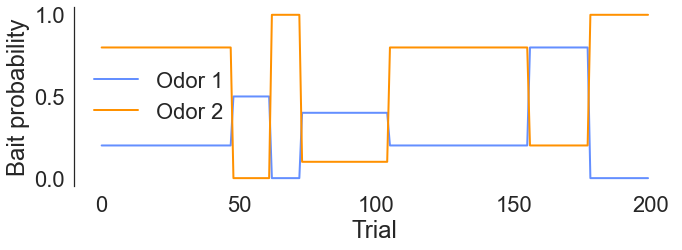

1/24: RewardLearner_acceptreject


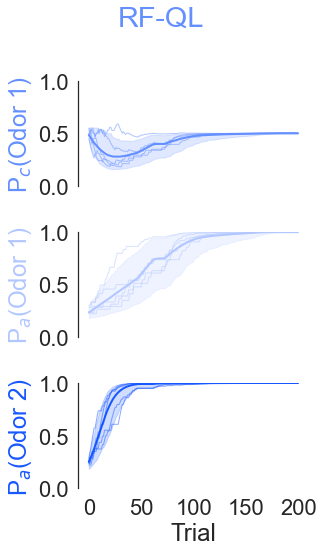

2/24: ForgettingRewardLearner_acceptreject


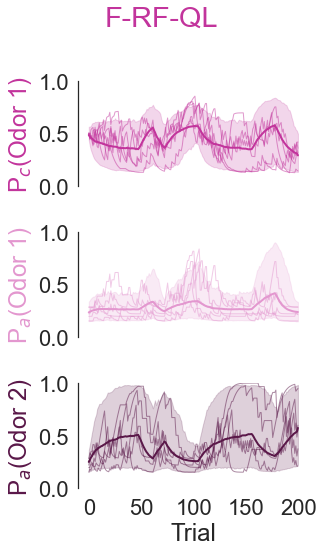

3/24: IQLearner_acceptreject


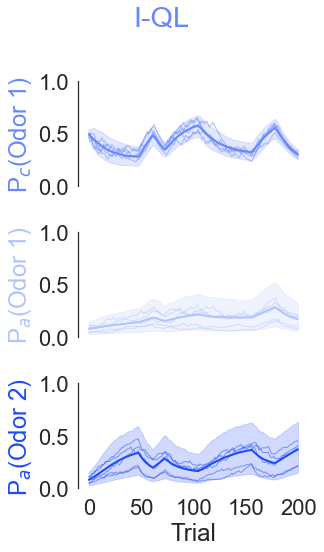

4/24: CQLearner_acceptreject


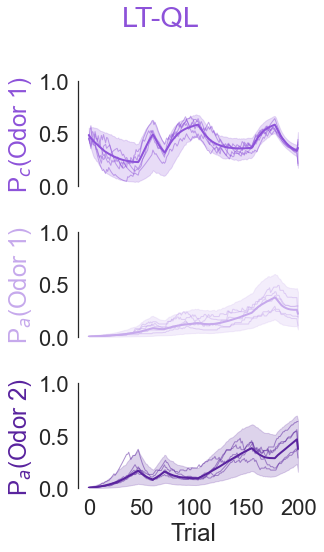

5/24: FQLearner_acceptreject


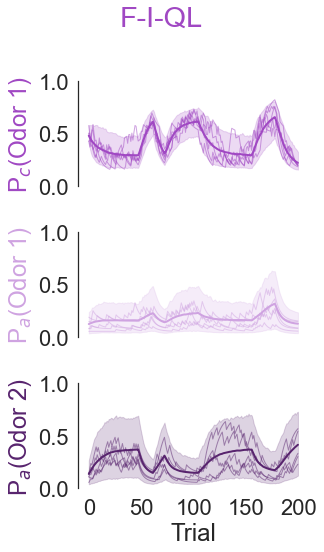

6/24: FCQLearner_acceptreject


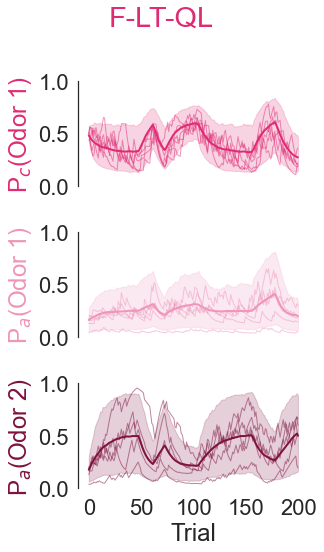

7/24: DFQLearner_acceptreject


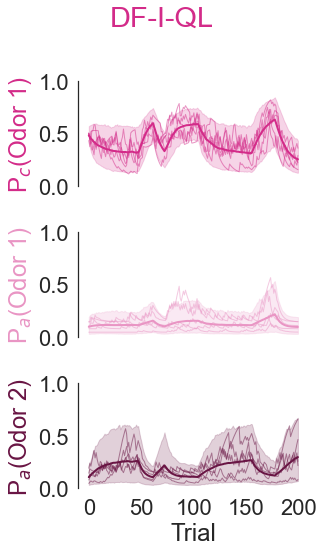

8/24: DFCQLearner_acceptreject


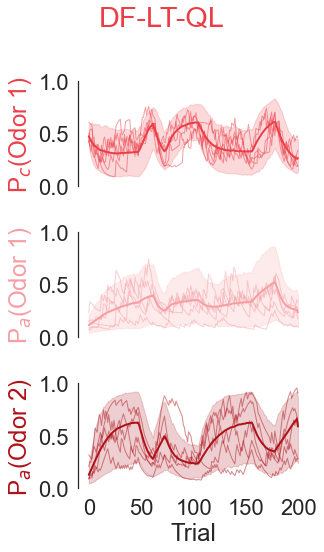

9/24: DEQLearner_acceptreject


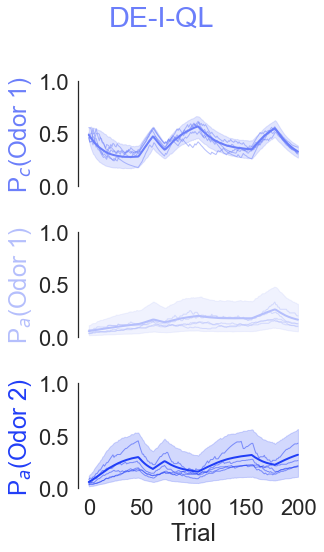

10/24: DECQLearner_acceptreject


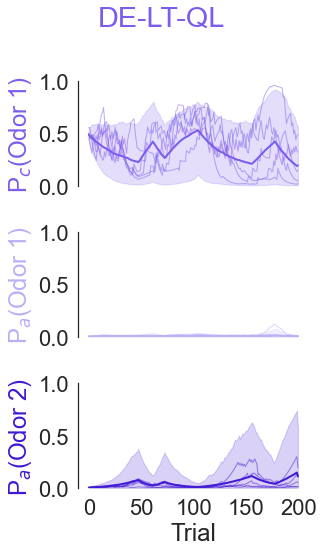

11/24: OSQLearner_acceptreject


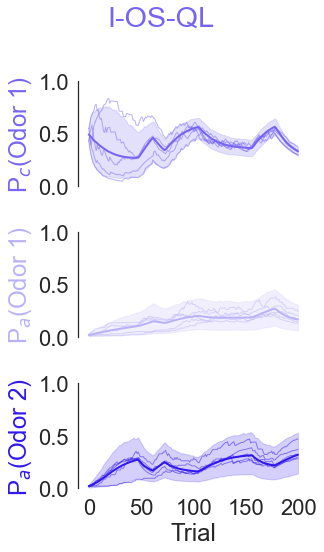

12/24: OSCQLearner_acceptreject


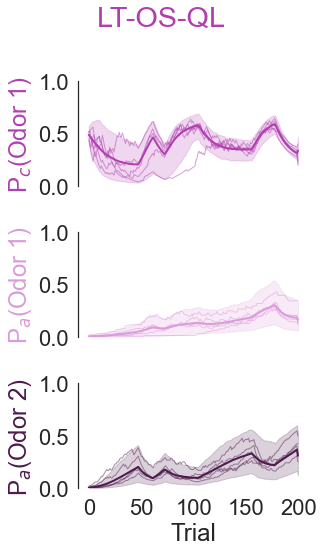

13/24: FOSQLearner_acceptreject


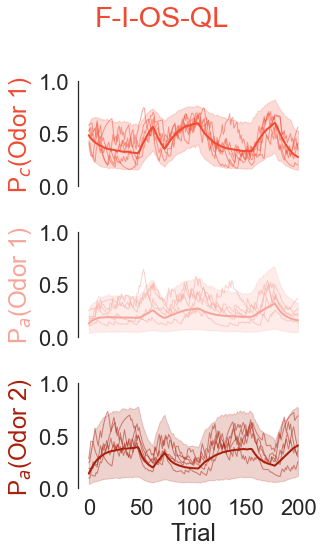

14/24: FOSCQLearner_acceptreject


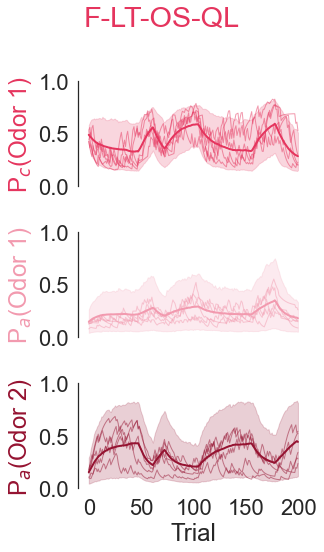

15/24: DFOSQLearner_acceptreject


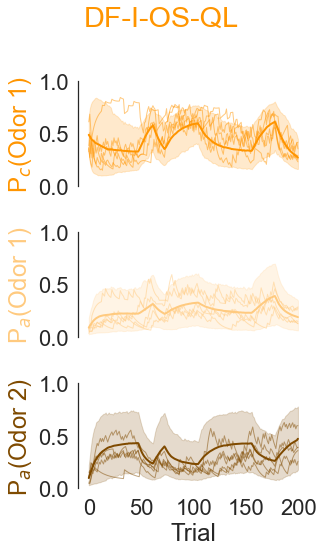

16/24: DFOSCQLearner_acceptreject


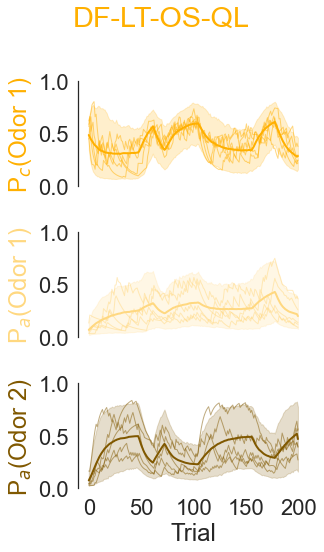

17/24: SARSALearner_acceptreject


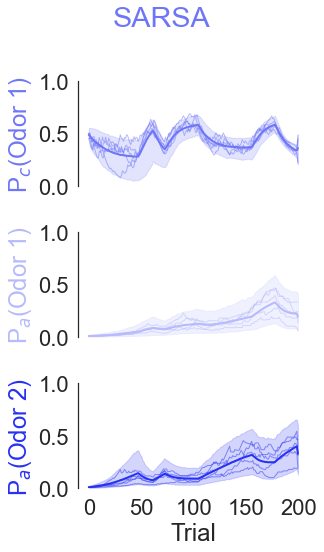

18/24: ESARSALearner_acceptreject


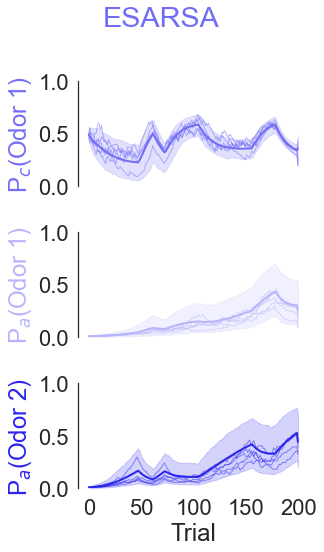

19/24: HQLearner_acceptreject


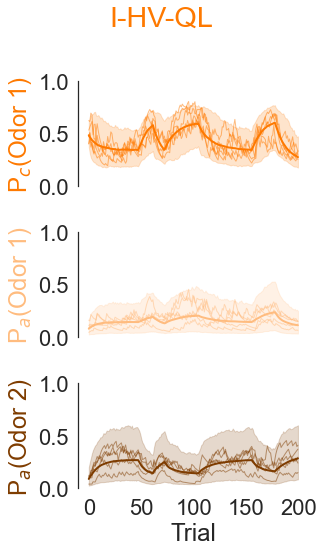

20/24: FHQLearner_acceptreject


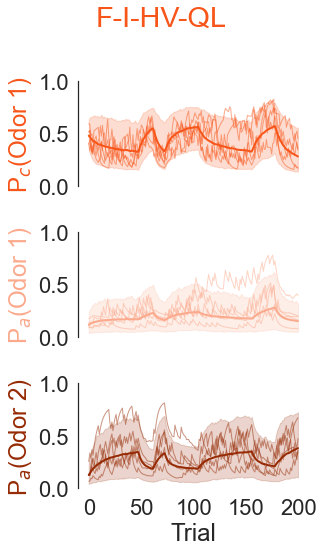

21/24: DFHQLearner_acceptreject


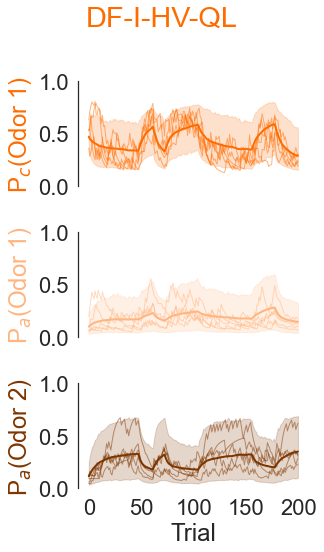

22/24: HCQLearner_acceptreject


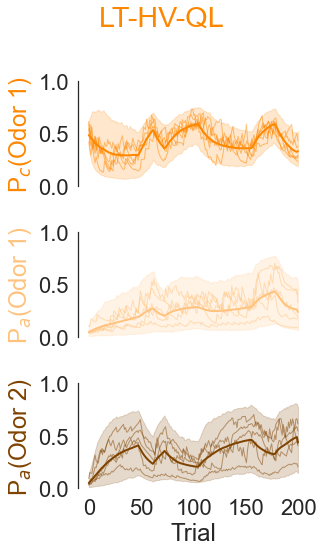

23/24: FHCQLearner_acceptreject


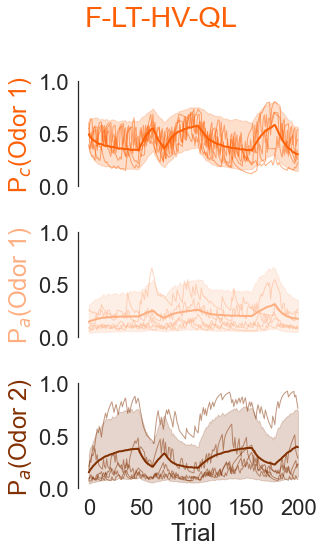

24/24: DFHCQLearner_acceptreject


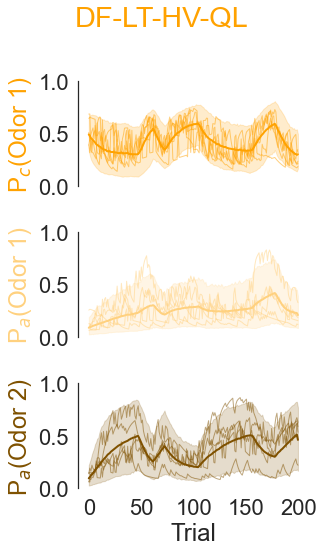

In [134]:
n_samples = 1000

overwrite = False

def sigmoid(x):
    return 1/(1+np.exp(-x))

np.random.seed(123)
# generate random experiment
block_sizes = np.random.geometric(0.025,20)
block_sizes = block_sizes[np.cumsum(block_sizes)<200]
block_sizes = np.append(block_sizes,200-np.sum(block_sizes))
# sample probabilities
gain = np.random.choice([0.5,0.25,0.125],len(block_sizes))
contrast = np.random.choice([0.8,1,0.6],len(block_sizes))
# generate schedule
p1 = gain+gain*contrast
p2 = gain-gain*contrast
temp = p1[::2].copy()
p1[::2] = p2[::2].copy()
p2[::2] = temp.copy()

p1_ = np.concatenate([[p1[i]]*block_sizes[i] for i in range(len(p1))])
p2_ = np.concatenate([[p2[i]]*block_sizes[i] for i in range(len(p2))])

sns.set(font_scale=2,style='white')
fig,ax = plt.subplots(1,1,figsize=(10,4))

ax.plot(np.arange(len(p1_)),p1_,linewidth=2,color=cmap(0.0),label='Odor 1')
ax.plot(np.arange(len(p2_)),p2_,linewidth=2,color=cmap(0.9),label='Odor 2')

ax.set_xticks(np.arange(0,201,50))
ax.set_xlabel('Trial')
ax.set_ylabel('Bait probability')

# turn off all spines except left
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)


ax.legend(frameon=False,loc='center left')

plt.tight_layout()
plt.savefig('figures/example_schedule.pdf',bbox_inches='tight')
plt.show()

for model_no,model in enumerate(model_classes):
    model_name = model.__name__
    print(str(model_no+1) + "/" + str(len(model_classes)) + ": " + model_name)
    model_abv = model_simple_abv_map[model_class_name_map[model_name]]
    color = cmap((comparison['Rank'].max()-comparison[comparison['Model']==model_abv]['Rank'].values)/comparison['Rank'].max())

    if not os.path.exists('data/' + model_name + '_wn_values.npz') or overwrite:
        try:
            params, policy_params = generate_params_from_fits(agentClass=model,n_samples=n_samples,sample_from_population=True)
        except Exception as e:
            print("Failed to generate params from fits")
            print(e)
            continue

        env = ymaze_baiting(n_trials_per_session=200, n_trial_per_blocks = block_sizes, baiting_probabilities=np.array([p1,p2]).T)
        weight = np.array([i['weight'] for i in policy_params])
        intercept = np.array([i['intercept'] for i in policy_params])
        values = get_schedule_values(env, model, n_samples, params, policy_params)
        values = sigmoid(np.array(values)*weight.reshape(-1,1,1) + intercept.reshape(-1,1,1))

        action_probs1 = values[:,:,0]*(3-values[:,:,1])/(3*values[:,:,0]+3*values[:,:,1]-2*values[:,:,0]*values[:,:,1])
        action_probs2 = values[:,:,1]*(3-values[:,:,0])/(3*values[:,:,0]+3*values[:,:,1]-2*values[:,:,0]*values[:,:,1])
        action_probs = np.stack([action_probs1,action_probs2],axis=2)

        np.savez_compressed('data/' + model_name + '_wn_values.npz',values=values,action_probs=action_probs)

    else:
        data = np.load('data/' + model_name + '_wn_values.npz')
        values = data['values']
        action_probs = data['action_probs']


    sns.set(font_scale=2.0,style='white')
    fig,ax = plt.subplots(3,1,figsize=(5,8),sharex=True)

    np.random.seed(15403997)
    sample = np.random.choice(np.arange(action_probs.shape[0]),size=5,replace=False)

    # plot action probabilities
    ax[0].plot(np.arange(action_probs.shape[1]),np.mean(action_probs[:,:,0],axis=0),linewidth=2,color=color)
    ax[0].fill_between(np.arange(action_probs.shape[1]),np.quantile(action_probs[:,:,0],0.025,axis=0),np.quantile(action_probs[:,:,0],0.975,axis=0),color=color,alpha=0.2)
    for i in sample:
        ax[0].plot(np.arange(action_probs.shape[1]),action_probs[i,:,0],linewidth=1,color=color,alpha=0.5)
    ax[0].set_ylabel(r'P$_c$(Odor 1)',color=color[0])
    ax[0].set_ylim(0,1)

    # plot acceptance probabilities
    ax[1].plot(np.arange(values.shape[1]),np.mean(values[:,:,0],axis=0),linewidth=2,color=change_lightness(color,0.5))
    ax[1].fill_between(np.arange(values.shape[1]),np.quantile(values[:,:,0],0.025,axis=0),np.quantile(values[:,:,0],0.975,axis=0),color=change_lightness(color,0.5),alpha=0.2)
    for i in sample:
        ax[1].plot(np.arange(values.shape[1]),values[i,:,0],linewidth=1,color=change_lightness(color,0.5),alpha=0.5)
    ax[1].set_ylabel(r'P$_a$(Odor 1)',color=change_lightness(color,0.5))
    ax[1].set_ylim(0,1)

    ax[2].plot(np.arange(values.shape[1]),np.mean(values[:,:,1],axis=0),linewidth=2,color=change_lightness(color,1.5))
    ax[2].fill_between(np.arange(values.shape[1]),np.quantile(values[:,:,1],0.025,axis=0),np.quantile(values[:,:,1],0.975,axis=0),color=change_lightness(color,1.5),alpha=0.2)
    for i in sample:
        ax[2].plot(np.arange(values.shape[1]),values[i,:,1],linewidth=1,color=change_lightness(color,1.5),alpha=0.5)
    ax[2].set_ylabel(r'P$_a$(Odor 2)',color=change_lightness(color,1.5))
    ax[2].set_ylim(0,1)

    # turn off all spines except left 
    for i in range(3):
        for spine in ax[i].spines.values():
            spine.set_visible(False)
        ax[i].spines['left'].set_visible(True)

    # set xticks
    ax[2].set_xticks(np.arange(0,201,50))
    ax[2].set_xlabel('Trial')

    # set title
    plt.suptitle(model_abv,color=color[0])

    plt.tight_layout()
    plt.savefig('figures/example_values_{}.pdf'.format(model_abv),bbox_inches='tight')
    plt.show()

Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/DFOSCQBR_2022_04_20_17_01_19.nc


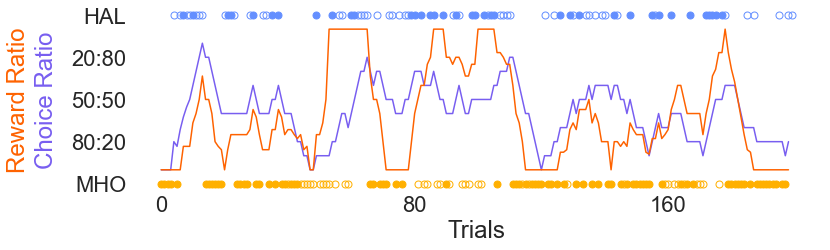

In [181]:
np.random.seed(123)
# generate random experiment
block_sizes = np.random.geometric(0.025,20)
block_sizes = block_sizes[np.cumsum(block_sizes)<200]
block_sizes = np.append(block_sizes,200-np.sum(block_sizes))
# sample probabilities
gain = np.random.choice([0.5,0.25,0.125],len(block_sizes))
contrast = np.random.choice([0.8,1,0.6],len(block_sizes))
# generate schedule
p1 = gain+gain*contrast
p2 = gain-gain*contrast
temp = p1[::2].copy()
p1[::2] = p2[::2].copy()
p2[::2] = temp.copy()

model_class = DFOSCQLearner_acceptreject
model_name = model_class.__name__
model_abv = model_simple_abv_map[model_class_name_map[model_name]]
try:
    params, policy_params = generate_params_from_fits(agentClass=model_class,n_samples=1,sample_from_population=True)
except:
    print("Failed to generate params from fits")
color = cmap((comparison['Rank'].max()-comparison[comparison.index==model_abv]['Rank'].values)/comparison['Rank'].max())
env = ymaze_baiting(n_trials_per_session=200, n_trial_per_blocks = block_sizes, baiting_probabilities=np.array([p1,p2]).T)
agent = model_class(env, params, policy_params)
agent.next_episode()
choice = np.array(agent.action_history)
reward = np.array(agent.reward_history)

odor_1_rewarded = np.where(np.logical_and(reward == 1, choice == 0))[0]
odor_2_rewarded = np.where(np.logical_and(reward == 1, choice == 1))[0]
odor_1_unrewarded = np.where(np.logical_and(reward == 0, choice == 0))[0]
odor_2_unrewarded = np.where(np.logical_and(reward == 0, choice == 1))[0]

window_size = 10

# plot the data
sns.set(style='white',font_scale=2)
fig, ax = plt.subplots(1,1, figsize=(12,4))

choice_ratio = np.convolve(choice == 0, np.ones(window_size), mode='full')[:-window_size]/(np.convolve(choice == 1, np.ones(window_size), mode='full')[:-window_size]+np.convolve(choice == 0, np.ones(window_size), mode='full')[:-window_size])
reward_ratio = np.convolve(np.logical_and(reward == 1,choice == 0), np.ones(window_size), mode='full')[:-window_size]/(np.convolve(np.logical_and(reward == 1,choice == 1), np.ones(window_size), mode='full')[:-window_size]+np.convolve(np.logical_and(reward == 1,choice == 0), np.ones(window_size), mode='full')[:-window_size])

ax.plot(2*choice_ratio-1, color=cmap(0.25))
ax.plot(2*reward_ratio-1, color=cmap(0.75))

limit = 1.2*np.max([np.max(np.abs(choice_ratio[~np.isnan(choice_ratio)])), np.max(np.abs(reward_ratio[~np.isnan(reward_ratio)]))])

ax.plot(odor_1_rewarded, limit*np.ones(len(odor_1_rewarded)), 'o', color=cmap(0.0), markersize=7)
ax.plot(odor_2_rewarded, -limit*np.ones(len(odor_2_rewarded)), 'o', color=cmap(1.0), markersize=7)
ax.plot(odor_1_unrewarded, limit*np.ones(len(odor_1_unrewarded)), 'o', color=cmap(0.0), markerfacecolor='none', markersize=7)
ax.plot(odor_2_unrewarded, -limit*np.ones(len(odor_2_unrewarded)), 'o', color=cmap(1.0), markerfacecolor='none', markersize=7)

plt.xticks([0,80,160])
plt.yticks([-limit,-0.6,0,0.6,limit],['MHO','80:20','50:50','20:80','HAL'])

plt.xlabel('Trials')
# add y labels manually
ax.text(-0.12, 0.5, 'Choice Ratio', ha='center', va='center', rotation='vertical', transform=ax.transAxes, color=cmap(0.25))
ax.text(-0.16, 0.5, 'Reward Ratio', ha='center', va='center', rotation='vertical', transform=ax.transAxes, color=cmap(0.75))

ax.tick_params(axis='both', which='both', length=0)
plt.box(False)
plt.tight_layout()
plt.savefig('figures/example_schedule_{}.pdf'.format(model_abv),bbox_inches='tight')
plt.show()


In [127]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def get_rolling_window(a, window, axis=0):
    if a.ndim == 1:
        return rolling_window(a, window)
    elif a.ndim == 2:
        return np.apply_along_axis(rolling_window, axis, a, window)
    elif a.ndim == 3:
        return np.apply_along_axis(get_rolling_window, axis, a, window)
    else:
        raise ValueError('Only 1, 2, or 3 dimensions are supported')

def local_variance(x, window=10,axis=0):
    return np.var(get_rolling_window(x, window, axis=axis), axis=axis+1)


In [132]:
n_samples = 1000
overwrite = False

def sigmoid(x):
    return 1/(1+np.exp(-x))

local_variances = {}

for model_no,model in enumerate(model_classes):
    model_name = model.__name__
    print(str(model_no+1) + "/" + str(len(model_classes)) + ": " + model_name)
    model_abv = model_simple_abv_map[model_class_name_map[model_name]]
    if not os.path.exists('data/local_variances_{}.npz'.format(model_abv)) or overwrite:
        try:
            params, policy_params = generate_params_from_fits(agentClass=model,n_samples=n_samples,sample_from_population=True)
        except Exception as e:
            print("Failed to generate params from fits")
            print(e)
            continue
        color = cmap((comparison['Rank'].max()-comparison[comparison.index==model_abv]['Rank'].values)/comparison['Rank'].max())

        values = []
        for sample_no in tqdm(range(n_samples)):
            np.random.seed(123+sample_no)
            # generate random experiment
            block_sizes = np.random.geometric(0.025,20)
            block_sizes = block_sizes[np.cumsum(block_sizes)<200]
            block_sizes = np.append(block_sizes,200-np.sum(block_sizes))
            # sample probabilities
            gain = np.random.choice([0.5,0.25,0.125],len(block_sizes))
            contrast = np.random.choice([0.8,1,0.6],len(block_sizes))
            # generate schedule
            p1 = gain+gain*contrast
            p2 = gain-gain*contrast
            temp = p1[::2].copy()
            p1[::2] = p2[::2].copy()
            p2[::2] = temp.copy()
            # generate schedule
            env = ymaze_baiting(n_trials_per_session=200, n_trial_per_blocks = block_sizes, baiting_probabilities=np.array([p1,p2]).T)
            value = get_agent_value_history(agentClass=model, params=params[sample_no], policy_params=policy_params[sample_no], env=env)
            values.append(value)
        
        values = np.array(values)

        weight = np.array([i['weight'] for i in policy_params])
        intercept = np.array([i['intercept'] for i in policy_params])
        values = sigmoid(np.array(values)*weight.reshape(-1,1,1) + intercept.reshape(-1,1,1))

        # calculate local variance
        window_size = 10
        values = local_variance(values, window_size, 1)

        # save
        np.savez_compressed('data/local_variances_{}.npz'.format(model_abv), values=values)
    else:
        values = np.load('data/local_variances_{}.npz'.format(model_abv))['values']
    
    local_variances[model_abv] = values.mean(axis=1).flatten()

local_variances = pd.DataFrame(local_variances)

1/24: RewardLearner_acceptreject
2/24: ForgettingRewardLearner_acceptreject
3/24: IQLearner_acceptreject
4/24: CQLearner_acceptreject
5/24: FQLearner_acceptreject
6/24: FCQLearner_acceptreject
7/24: DFQLearner_acceptreject
8/24: DFCQLearner_acceptreject
9/24: DEQLearner_acceptreject
10/24: DECQLearner_acceptreject
11/24: OSQLearner_acceptreject
12/24: OSCQLearner_acceptreject
13/24: FOSQLearner_acceptreject
14/24: FOSCQLearner_acceptreject
15/24: DFOSQLearner_acceptreject
16/24: DFOSCQLearner_acceptreject
17/24: SARSALearner_acceptreject
18/24: ESARSALearner_acceptreject
19/24: HQLearner_acceptreject
20/24: FHQLearner_acceptreject
21/24: DFHQLearner_acceptreject
22/24: HCQLearner_acceptreject
23/24: FHCQLearner_acceptreject
24/24: DFHCQLearner_acceptreject


0it [00:00, ?it/s]

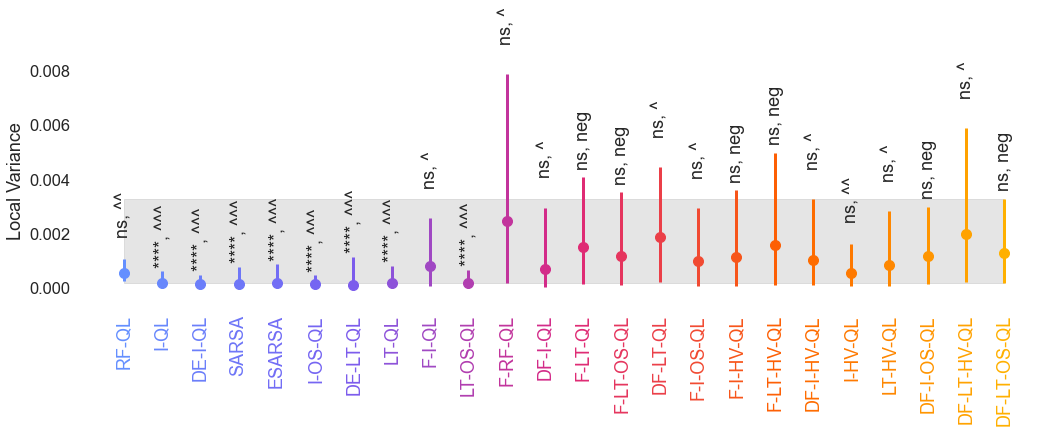

In [180]:
# plot as errorbar
sns.set(style='white',font_scale=1.5)
fig, ax = plt.subplots(figsize=(15,7))

# reorder columns by rank
local_variances = local_variances[comparison['Model'].values]

# get values of the last column
best_model = local_variances[local_variances.columns[-1]].values

statistics = []

for i,model_abv in tqdm(enumerate(local_variances.columns)):
    color = cmap((comparison['Rank'].max()-comparison[comparison.Model==model_abv]['Rank'].values)/comparison['Rank'].max())
    y = [np.mean(local_variances[model_abv].values)]
    upper = np.percentile(local_variances[model_abv].values, 97.5)
    lower = np.percentile(local_variances[model_abv].values, 2.5)

    # calculate p value by taking 1000 samples from the model
    ps = []
    for j in range(1000):
        n_data = len(local_variances[model_abv].values)
        index = np.random.choice(n_data, 18)
        samplex = local_variances[model_abv].values[index]
        sampley = best_model[index]
        ps.append(stats.mannwhitneyu(samplex, sampley)[1])
    p = np.quantile(ps, 0.95)
    # effect size
    d = cliffsDelta(local_variances[model_abv].values, best_model)
    statistics.append([model_abv, "{:.4f}".format(y[0]), "({:.4f}–{:.4f})".format(lower, upper), p, d])

    ax.errorbar(i, y, yerr=(y-lower,upper-y), color=color, marker='o', markersize=10, linewidth=3)
    # add stars
    ax.text(i, upper+0.0025, pvalue_to_stars(p) + ', ' + d_to_effect(d), ha='center', va='top',rotation=90)
    ax.text(i, -0.001, model_abv, ha='center', va='top', rotation='vertical', color=color[0])

# plot reference region for the last model
ax.fill_between([0,local_variances.shape[1]-1], lower, upper, color='gray', alpha=0.2)

plt.xticks([])
plt.ylabel('Local Variance')
plt.box(False)
plt.tight_layout()
plt.savefig('figures/local_variance.pdf',bbox_inches='tight')
plt.show()

statistics = pd.DataFrame(statistics, columns=['Model','Mean','95% CI','p','d'])
statistics.to_csv('tables/local_variance.csv', index=False)

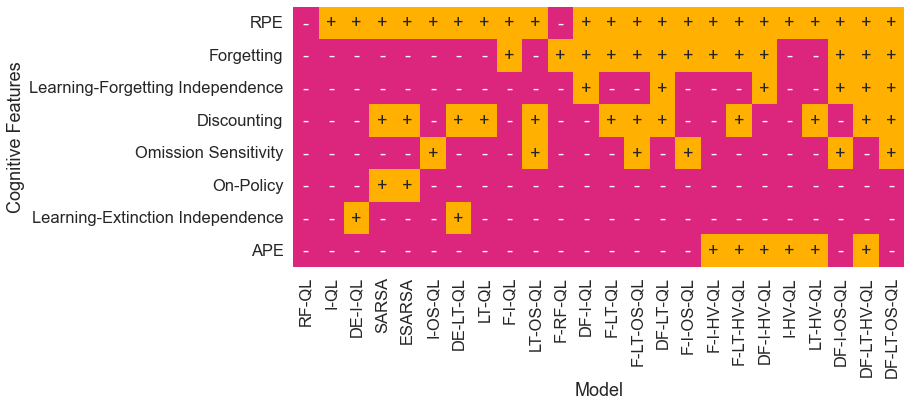

In [182]:
cognitive_features = model_database.groupby(['ModelAbv']).aggregate({i:'first' for i in model_database.columns[-8:]}).reset_index()
cognitive_features = cognitive_features.rename(columns={'ModelAbv':'model'})
cognitive_features.index = cognitive_features['model']
cognitive_features = cognitive_features.drop('model', axis=1)
cognitive_features = cognitive_features.loc[comparison['Model'].values]
cognitive_features_annots = cognitive_features.values
cognitive_features = cognitive_features.replace({'+':1,'-':0})
# plot as a heatmap
sns.set(style='white',font_scale=1.5)
fig, ax = plt.subplots(figsize=(13,6))
sns.heatmap(cognitive_features.T, cmap=cmap, vmin=-1, vmax=1, center=0, annot=cognitive_features_annots.T, fmt='', cbar=False, ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('Model')
plt.ylabel('Cognitive Features')
plt.tight_layout()
plt.savefig('../../MS_Thesis/Figures/fig_34.pdf',bbox_inches='tight')
plt.savefig('../../MS_Thesis/Figures/main_figures/fig_34.png',bbox_inches='tight')
plt.show()
# reorder columns by rank


  0%|          | 0/1000 [00:00<?, ?it/s]

1/24: RewardLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/RBR_2022_04_09_19_31_45.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

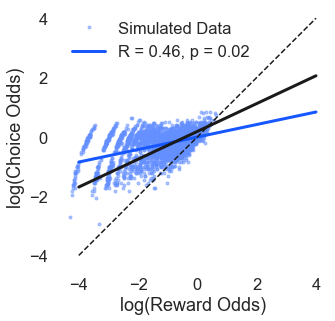

2/24: ForgettingRewardLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/FRBR_2022_04_22_22_08_26.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

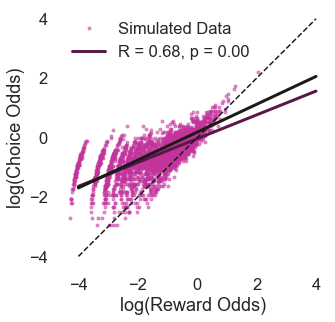

3/24: IQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/IQBR_2022_04_05_09_06_43.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

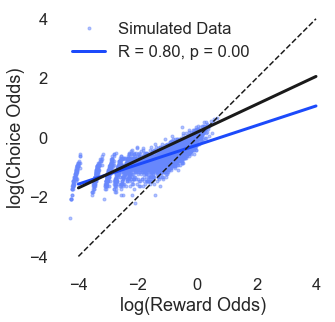

4/24: CQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/CQBR_2022_04_07_14_56_03.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

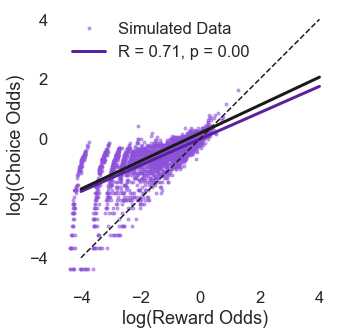

5/24: FQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/FQBR_2022_04_07_14_56_35.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

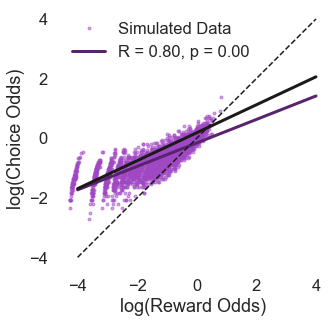

6/24: FCQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/FCQBR_2022_04_07_14_56_43.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

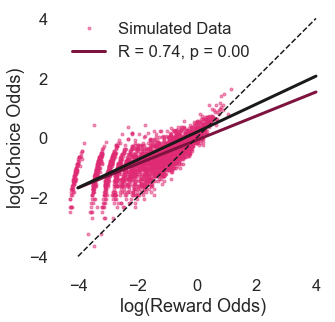

7/24: DFQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/DFQBR_2022_04_22_22_06_02.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

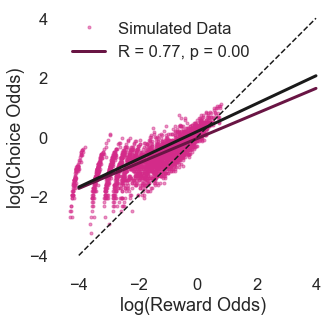

8/24: DFCQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/DFCQBR_2022_04_20_17_02_18.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

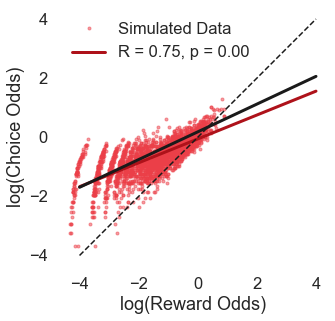

9/24: DEQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/DEQBR_2022_04_09_13_43_11.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

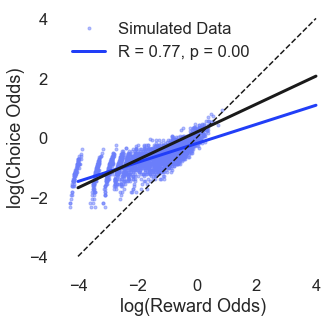

10/24: DECQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/DECQBR_2022_04_09_13_43_22.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

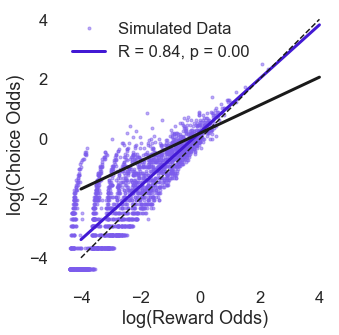

11/24: OSQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/OSQBR_2022_04_09_19_41_05.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

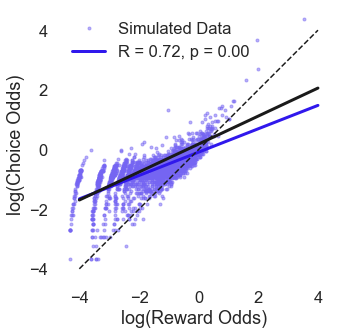

12/24: OSCQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/OSCQBR_2022_04_09_19_41_05.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

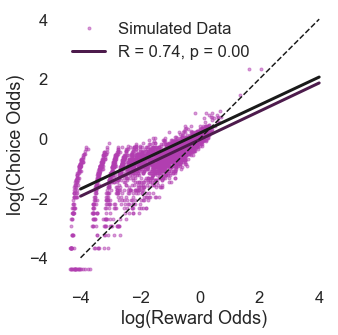

13/24: FOSQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/FOSQBR_2022_04_12_14_09_52.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

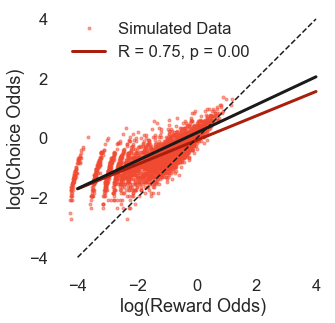

14/24: FOSCQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/FOSCQBR_2022_04_12_14_09_37.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

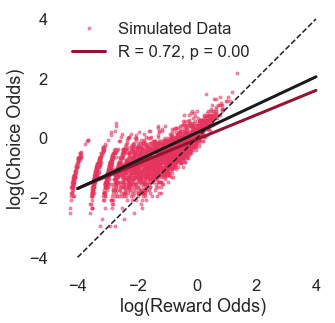

15/24: DFOSQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/DFOSQBR_2022_04_20_17_01_19.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

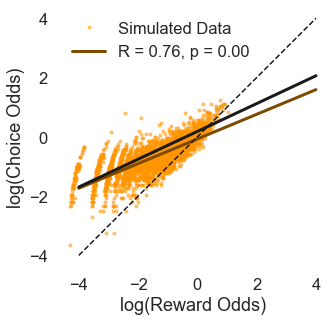

16/24: DFOSCQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/DFOSCQBR_2022_04_20_17_01_19.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

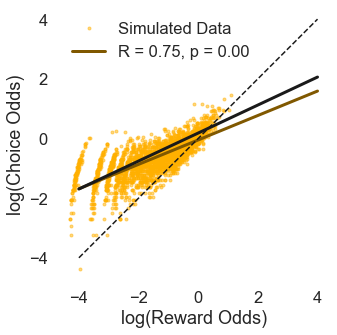

17/24: SARSALearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/SBR_2022_04_11_11_01_06.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

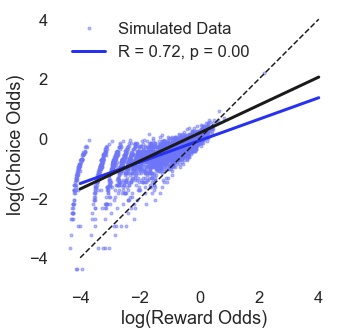

18/24: ESARSALearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/ESBR_2022_04_11_15_43_12.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

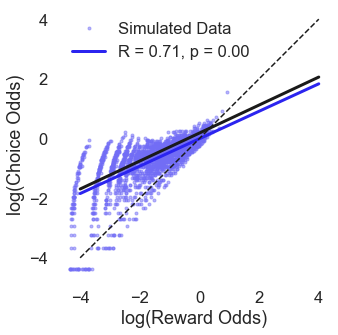

19/24: HQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/HQBR_2022_04_11_16_15_55.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

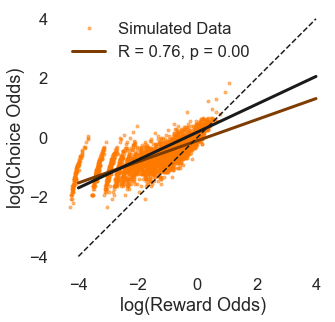

20/24: FHQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/FHQBR_2022_04_22_22_09_26.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

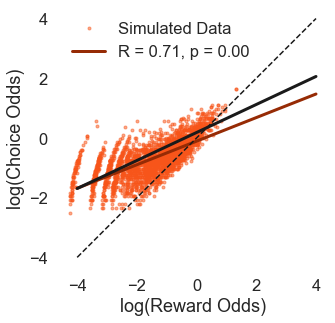

21/24: DFHQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/DFHQBR_2022_10_01_01_29_31.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

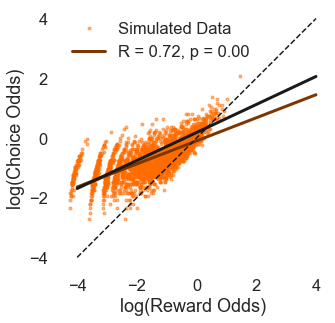

22/24: HCQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/HCQBR_2022_04_11_16_15_56.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

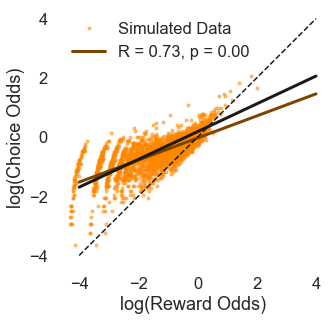

23/24: FHCQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/FHCQBR_2022_04_22_22_09_23.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

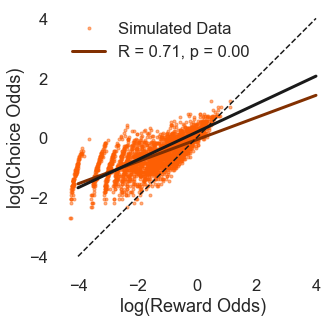

24/24: DFHCQLearner_acceptreject
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/DFHCQBR_2022_10_01_01_30_08.nc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

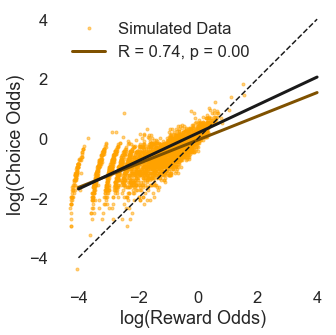

In [ ]:
# # matching coomparison

# matching_data = {}

# generalized_matching_law = True
# overwrite = False

# choice_ratios = []
# reward_ratios = []
# for fly in range(len(training_choice_set)):
#     for trial in range(80,len(training_choice_set[fly])+41,80):
#         choice_sample = training_choice_set[fly, trial-80:trial]
#         reward_sample = training_reward_set[fly, trial-80:trial]

#         if generalized_matching_law:
#             choice_ratio = np.log(np.sum(choice_sample==0))-np.log(np.sum(choice_sample==1))
#             reward_ratio = np.log(np.sum(np.logical_and(choice_sample==0,reward_sample==1)))-np.log(np.sum(np.logical_and(choice_sample==1,reward_sample==1)))
#         else:
#             choice_ratio = np.sum(choice_sample==0)/(np.sum(choice_sample==1)+np.sum(choice_sample==0))
#             reward_ratio = np.sum(np.logical_and(choice_sample==0,reward_sample==1))/(np.sum(np.logical_and(choice_sample==0,reward_sample==1))+np.sum(np.logical_and(choice_sample==1,reward_sample==1)))

#         choice_ratios.append(choice_ratio)
#         reward_ratios.append(reward_ratio)

# choice_ratios = np.array(choice_ratios)
# reward_ratios = np.array(reward_ratios)

# acceptable_indices = np.logical_and(np.logical_and(np.isnan(choice_ratios)==False,np.isnan(reward_ratios)==False),np.logical_and(np.isinf(choice_ratios)==False,np.isinf(reward_ratios)==False))
# choice_ratios = choice_ratios[acceptable_indices]
# reward_ratios = reward_ratios[acceptable_indices]

# n_bootstraps = 1000
# bootstrapped_linear_fit = []
# for i in tqdm(range(n_bootstraps)):
#     bootstrap_indices = np.random.choice(np.arange(len(choice_ratios)),len(choice_ratios),replace=True)
#     bootstrap_choice_ratios = choice_ratios[bootstrap_indices]
#     bootstrap_reward_ratios = reward_ratios[bootstrap_indices]

#     slope_t, intercept_t, r_value, p_value, std_err = stats.linregress(bootstrap_reward_ratios,bootstrap_choice_ratios)
#     bootstrapped_linear_fit.append([slope_t, intercept_t, r_value, p_value, std_err])

# bootstrapped_linear_fit = pd.DataFrame(bootstrapped_linear_fit,columns=['Slope','Intercept','R','P','SE'])

# x_data = np.linspace(-4,4,100)
# y_data = bootstrapped_linear_fit['Slope'].median()*x_data + bootstrapped_linear_fit['Intercept'].median()

# matching_data['Observed'] = bootstrapped_linear_fit

# n_samples = 18
# repeats = 50
# n_blocks = 3
# size_block = 80

# for model_no,model in enumerate(model_classes):
#     model_name = model.__name__
#     print(str(model_no+1) + "/" + str(len(model_classes)) + ": " + model_name)
#     model_abv = model_simple_abv_map[model_class_name_map[model_name]]
#     color = cmap((combined['Rank'].max()-combined[combined['Model']==model_abv]['Rank'].values)/combined['Rank'].max())
#     if len(color)==0:
#         color = cmap(0.5)

#     if (not os.path.exists('data/matching_data_wide_' + model_abv + '.npz')) or overwrite:
#         try:
#             params, policy_params = generate_params_from_fits(agentClass=model,n_samples=n_samples,sample_from_population=True)
#         except:
#             print("Failed to generate params from fits")
#             continue
        
#         choice_set = []
#         reward_set = []
#         for r in tqdm(range(repeats)):
#             for i in range(n_samples):
#                 p_vals = np.random.choice([1-0.5,1-0.25,1-0.125,1-0.0625],n_blocks)
#                 sum = np.random.choice([0.5])
#                 p_vals = p_vals*sum
#                 start_index = np.random.choice(2)
#                 p_vals[start_index::2] = sum-p_vals[start_index::2]
#                 env = ymaze_baiting(n_trials_per_session=size_block*n_blocks, n_trial_per_blocks = [size_block]*n_blocks, baiting_probabilities=[[p_vals[k],1-p_vals[k]] for k in range(n_blocks)])
#                 agent = model(env, params[i], policy_params[i])
#                 agent.next_episode()
#                 choice_set.append(agent.action_history)
#                 reward_set.append(agent.reward_history)
        
#         choice_set = np.array(choice_set)
#         reward_set = np.array(reward_set)
#         np.savez_compressed('data/matching_data_wide_' + model_abv + '.npz',choice_set=choice_set,reward_set=reward_set)
#     else:
#         data = np.load('data/matching_data_wide_' + model_abv + '.npz')
#         choice_set = data['choice_set']
#         reward_set = data['reward_set']

#     sns.set(font_scale=1.5)
#     fig, ax = plt.subplots(figsize=(5,5))
    
#     choice_ratios = []
#     reward_ratios = []
#     for fly in range(len(choice_set)):
#         for trial in range(80,len(choice_set[fly])+41,80):
#             choice_sample = choice_set[fly, trial-80:trial]
#             reward_sample = reward_set[fly, trial-80:trial]

#             if generalized_matching_law:
#                 choice_ratio = np.log(np.sum(choice_sample==0))-np.log(np.sum(choice_sample==1))
#                 reward_ratio = np.log(np.sum(np.logical_and(choice_sample==0,reward_sample==1)))-np.log(np.sum(np.logical_and(choice_sample==1,reward_sample==1)))
#             else:
#                 choice_ratio = np.sum(choice_sample==0)/(np.sum(choice_sample==1)+np.sum(choice_sample==0))
#                 reward_ratio = np.sum(np.logical_and(choice_sample==0,reward_sample==1))/(np.sum(np.logical_and(choice_sample==0,reward_sample==1))+np.sum(np.logical_and(choice_sample==1,reward_sample==1)))


#             choice_ratios.append(choice_ratio)
#             reward_ratios.append(reward_ratio)

#     choice_ratios = np.array(choice_ratios)
#     reward_ratios = np.array(reward_ratios)

#     acceptable_indices = np.logical_and(np.logical_and(np.isnan(choice_ratios)==False,np.isnan(reward_ratios)==False),np.logical_and(np.isinf(choice_ratios)==False,np.isinf(reward_ratios)==False))
#     choice_ratios = choice_ratios[acceptable_indices]
#     reward_ratios = reward_ratios[acceptable_indices]
#     plt.plot(reward_ratios,choice_ratios,'.',alpha=0.5,label='Simulated Data',color=color)

#     n_bootstraps = 1000
#     bootstrapped_linear_fit = []
#     for i in tqdm(range(n_bootstraps)):
#         bootstrap_indices = np.random.choice(np.arange(len(choice_ratios)),len(choice_ratios)//repeats,replace=True)
#         bootstrap_choice_ratios = choice_ratios[bootstrap_indices]
#         bootstrap_reward_ratios = reward_ratios[bootstrap_indices]

#         slope_t, intercept_t, r_value, p_value, std_err = stats.linregress(bootstrap_reward_ratios,bootstrap_choice_ratios)
#         bootstrapped_linear_fit.append([slope_t, intercept_t, r_value, p_value, std_err])

#     bootstrapped_linear_fit = pd.DataFrame(bootstrapped_linear_fit,columns=['Slope','Intercept','R','P','SE'])

#     matching_data[model_abv] = bootstrapped_linear_fit

#     x = np.linspace(-4,4,100)
#     y = bootstrapped_linear_fit['Slope'].mean()*x + bootstrapped_linear_fit['Intercept'].mean()
#     plt.plot(x,y,'-',color=change_lightness(color,1.5), \
#             linewidth=3,label='R = %.2f, p = %.2f' % (bootstrapped_linear_fit['R'].mean(),bootstrapped_linear_fit['P'].mean()))
#     plt.plot(x_data,y_data,'-',color='k',linewidth=3)
    
#     if generalized_matching_law:
#         plt.xlabel('log(Reward Odds)')
#         plt.ylabel('log(Choice Odds)')
#     else:
#         plt.xlabel(r'Reward Ratio ($\frac{R_{1}}{R_{1}+R_{2}}$)')
#         plt.ylabel(r'Choice Ratio ($\frac{C_{1}}{C_{1}+C_{2}}$)')
#     plt.plot(x,x,'k--')
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.box(False)
#     plt.tight_layout()
#     plt.legend(frameon=False)
#     plt.savefig(f"figures/Matching_wide_{model_abv}.pdf",bbox_inches='tight')
#     plt.show()


In [ ]:
# # make into a dataframe
# matching_data = pd.concat(matching_data).reset_index()
# matching_data = matching_data.rename(columns={'level_0':'Model','level_1':'Bootstrap'})
# if generalized_matching_law:
#     # rename the slope and intercept
#     matching_data.columns = ['Model','Bootstrap','Matching Strength','Bias','R','P','SE']
# # save
# matching_data.to_csv('data/matching_data_wide.csv',index=False)

In [ ]:
# # load data
# matching_data = pd.read_csv('data/matching_data_wide.csv')
# matching_data.head()

Model  Bootstrap  Matching Strength      Bias         R             P  \
0  Observed          0           0.436860  0.182402  0.812968  2.475615e-13   
1  Observed          1           0.380335  0.122018  0.787861  4.194928e-12   
2  Observed          2           0.450619  0.140776  0.830847  2.514010e-14   
3  Observed          3           0.499387  0.174802  0.753901  1.108387e-10   
4  Observed          4           0.458331  0.263101  0.820446  9.807943e-14   

         SE  
0  0.044252  
1  0.042045  
2  0.042684  
3  0.061545  
4  0.045168

In [ ]:
# # compare significance of observed data with model data using mann-whitney u test

# if generalized_matching_law:
#     matching_strength_sig = {}
#     bias_sig = {}
#     matching_strength_effect = {}
#     bias_effect = {}
# else:
#     slope_sig = {}
#     intercept_sig = {}
#     slope_effect = {}
#     intercept_effect = {}

# subsample = 18
# n_subsample = 1000

# obs = matching_data[matching_data['Model']=='Observed']
# for model in tqdm(matching_data['Model'].unique()):
#     if model=='Observed':
#         continue

#     mod = matching_data[matching_data['Model']==model]
    
#     if generalized_matching_law:
#         matching_strength_sig[model] = []
#         bias_sig[model] = []
#     else:
#         slope_sig[model] = []
#         intercept_sig[model] = []

#     for i in range(n_subsample):
#         obs_sub = obs.sample(subsample)
#         mod_sub = mod.sample(subsample)
#         if generalized_matching_law:
#             matching_strength_sig[model].append(stats.mannwhitneyu(obs_sub['Matching Strength'],mod_sub['Matching Strength'])[1])
#             bias_sig[model].append(stats.mannwhitneyu(obs_sub['Bias'],mod_sub['Bias'])[1])
#         else:
#             slope_sig[model].append(stats.mannwhitneyu(obs_sub['Slope'],mod_sub['Slope'])[1])
#             intercept_sig[model].append(stats.mannwhitneyu(obs_sub['Intercept'],mod_sub['Intercept'])[1])
    
#     # get the 95% percentile of pvalues
#     if generalized_matching_law:
#         matching_strength_sig[model] = np.quantile(matching_strength_sig[model],0.95)
#         bias_sig[model] = np.quantile(bias_sig[model],0.95)
#     else:
#         slope_sig[model] = np.quantile(slope_sig[model],0.95)
#         intercept_sig[model] = np.quantile(intercept_sig[model],0.95)
    
#     if generalized_matching_law:
#         matching_strength_effect[model] = cliffsDelta(obs['Matching Strength'].values,mod['Matching Strength'].values)
#         bias_effect[model] = cliffsDelta(obs['Bias'].values,mod['Bias'].values)
#     else:
#         slope_effect[model] = cliffsDelta(obs['Slope'].values,mod['Slope'].values)
#         intercept_effect[model] = cliffsDelta(obs['Intercept'].values,mod['Intercept'].values)
        

# if generalized_matching_law:
#     matching_strength_sig = pd.DataFrame.from_dict(matching_strength_sig,orient='index',columns=['p-value'])
#     bias_sig = pd.DataFrame.from_dict(bias_sig,orient='index',columns=['p-value'])
#     matching_strength_effect = pd.DataFrame.from_dict(matching_strength_effect,orient='index',columns=['Effect Size'])
#     bias_effect = pd.DataFrame.from_dict(bias_effect,orient='index',columns=['Effect Size'])
# else:
#     slope_sig = pd.DataFrame.from_dict(slope_sig,orient='index',columns=['p-value'])
#     intercept_sig = pd.DataFrame.from_dict(intercept_sig,orient='index',columns=['p-value'])
#     slope_effect = pd.DataFrame.from_dict(slope_effect,orient='index',columns=['Effect Size'])
#     intercept_effect = pd.DataFrame.from_dict(intercept_effect,orient='index',columns=['Effect Size'])

# # convert p-values to significance
# if generalized_matching_law:
#     matching_strength_sig['Significance'] = matching_strength_sig['p-value'].apply(pvalue_to_stars)
#     bias_sig['Significance'] = bias_sig['p-value'].apply(pvalue_to_stars)
#     matching_strength_effect['Effect'] = matching_strength_effect['Effect Size'].apply(delta_to_effect)
#     bias_effect['Effect'] = bias_effect['Effect Size'].apply(delta_to_effect)
# else:
#     slope_sig['Significance'] = slope_sig['p-value'].apply(pvalue_to_stars)
#     intercept_sig['Significance'] = intercept_sig['p-value'].apply(pvalue_to_stars)
#     slope_effect['Effect'] = slope_effect['Effect Size'].apply(delta_to_effect)
#     intercept_effect['Effect'] = intercept_effect['Effect Size'].apply(delta_to_effect)
    
    

  0%|          | 0/25 [00:00<?, ?it/s]

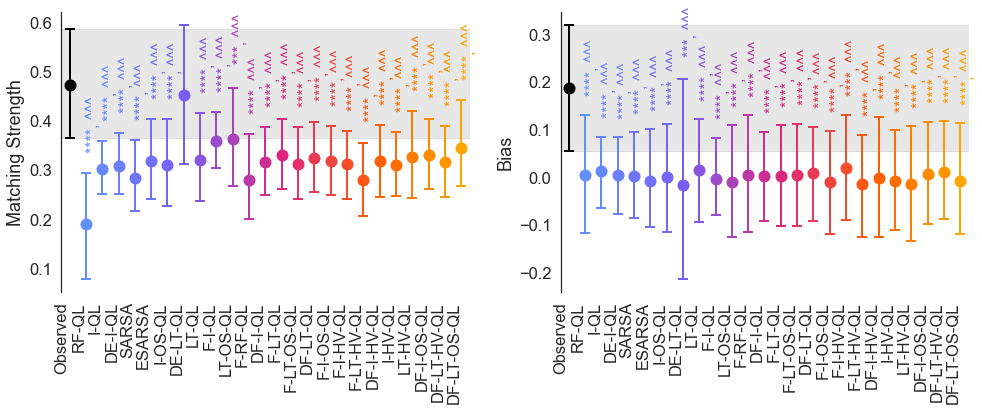

In [ ]:
# sns.set(font_scale=1.5,style='white')
# fig, ax = plt.subplots(1,2,figsize=(14,6))

# var1 = 'Matching Strength' if generalized_matching_law else 'Slope'
# var2 = 'Bias' if generalized_matching_law else 'Intercept'

# # plot slope on top
# order = ["Observed"]+list(comparison.Model.values)
# colors = [(0.,0.,0.)]+[cmap(model_no/len(model_classes)) for model_no in range(len(model_classes))]

# x = np.arange(len(matching_data['Model'].unique()))
# y = matching_data.groupby('Model').mean()[var1].loc[order].values
# upper = matching_data.groupby('Model').quantile(0.975)[var1].loc[order].values
# lower = matching_data.groupby('Model').quantile(0.025)[var1].loc[order].values

# for i in range(len(x)):
#     ax[0].errorbar(x[i],y[i],yerr=[[y[i]-lower[i]],[upper[i]-y[i]]],color=colors[i],
#                     linewidth=2,marker='o',markersize=10,markerfacecolor=colors[i],markeredgecolor=colors[i],
#                     markeredgewidth=2,capsize=5,capthick=2)
#     # add significance
#     if generalized_matching_law and i>0:
#         if matching_strength_sig['Significance'].loc[order[i]] != 'ns':
#             ax[0].text(x[i],upper[i]+0.1,matching_strength_sig['Significance'].loc[order[i]] + ', ' + matching_strength_effect['Effect'].loc[order[i]],ha='left',va='center', rotation=90, fontsize=16, color=colors[i])
#     elif i>0:
#         if slope_sig['Significance'].loc[order[i]] != 'ns':
#             ax[0].text(x[i],upper[i]+0.1,slope_sig['Significance'].loc[order[i]] + ', ' + slope_effect['Effect'].loc[order[i]],ha='left',va='center', rotation=90, fontsize=16, color=colors[i])

# # draw observed data significance bounds
# ax[0].fill_betweenx([lower[0],upper[0]],-1,len(x),color='k',alpha=0.1)
# ax[0].set_xticks(x)
# ax[0].set_xticklabels(order,rotation=90,ha='right')
# ax[0].set_ylabel(var1)
# ax[0].set_xlim(-0.5,len(x)-0.5)

# # plot intercept on bottom
# y = matching_data.groupby('Model').mean()[var2].loc[order].values
# upper = matching_data.groupby('Model').quantile(0.975)[var2].loc[order].values
# lower = matching_data.groupby('Model').quantile(0.025)[var2].loc[order].values

# for i in range(len(x)):
#     ax[1].errorbar(x[i],y[i],yerr=[[y[i]-lower[i]],[upper[i]-y[i]]],color=colors[i],
#                     linewidth=2,marker='o',markersize=10,markerfacecolor=colors[i],markeredgecolor=colors[i],
#                     markeredgewidth=2,capsize=5,capthick=2)
#     # add significance
#     if generalized_matching_law and i>0:
#         if bias_sig['Significance'].loc[order[i]] != 'ns':
#             ax[1].text(x[i],upper[i]+0.1,bias_sig['Significance'].loc[order[i]] + ', ' + bias_effect['Effect'].loc[order[i]],ha='left',va='center', rotation=90, fontsize=16, color=colors[i])
#     elif i>0:
#         if intercept_sig['Significance'].loc[order[i]] != 'ns':
#             ax[1].text(x[i],upper[i]+0.1,intercept_sig['Significance'].loc[order[i]] + ', ' + intercept_effect['Effect'].loc[order[i]],ha='left',va='center', rotation=90, fontsize=16, color=colors[i])


# # draw observed data significance bounds
# ax[1].fill_betweenx([lower[0],upper[0]],-1,len(x),color='k',alpha=0.1)
# ax[1].set_xticks(x)
# ax[1].set_xticklabels(order,rotation=90,ha='right')
# ax[1].set_ylabel(var2)
# ax[1].set_xlim(-0.5,len(x)-0.5)


# # turn off all spines except left
# for i in range(2):
#     for spine in ax[i].spines.values():
#         spine.set_visible(False)
#     ax[i].spines['left'].set_visible(True)

# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.savefig('figures/Matching_high_Slope_Intercept.pdf',bbox_inches='tight')
# plt.show()
